# Create land surface dataset for CLM6
- Authors: Jiang Zhu (jiangzhu@ucar.edu) with help from Sophia Macarewich (macarew@ucar.edu)
- Objective: Generate land surface properties for the Last Glacial Maximum (LGM), including exposed continental shelves and ice sheets based on ICE-6G reconstructions.
- Workflow
  - Step 1: Fill some raw data with nearest neighbor, such as LAI, soil color, FMAX, etc. (These do not impact land units: vegetation/crop, lake, glacier, and urban).
  - Step 2: Remove lakes beneath LGM ice sheets.
  - Step 3: Modify PFTs for LGM, including shelf exposure and glacier regions.
  - Step 4: Create LGM glacier files.
  - Step 5: Run mksurfdat_esmf.
- Notes
  - The key is creating a set of LGM raw files for land surface properties and the associated namelist.  
  - **Workflow differs from previous versions: raw files are modified directly (instead of regridding into 0.5°) before running mksurfdat_esmf.**
  - We use "noanthro" mode of CTSM without anthropogenic influences.
  - Use large memory (>60 GB on Casper).
- Tools used
  - [mksurfdata_esmf](https://github.com/ESCOMP/CTSM/tree/master/tools/mksurfdata_esmf) - generates CLM-compatible land surface files.
  - [f90nml](https://github.com/marshallward/f90nml) – for reading/writing Fortran namelist files.
  - NCO (run with `subprocess`)
  - I used  NCAR Python Library (NPL) 2026a.
- References
  - [CTSM Tech Note](https://escomp.github.io/ctsm-docs/versions/release-clm5.0/html/index.html)
  - [GitHub Discussion](https://github.com/ESCOMP/CTSM/discussions/1919)
  - [GitHub Issues](https://github.com/ESCOMP/CTSM/issues/578)

In [1]:
import subprocess
import datetime
import copy
import f90nml
import re
from pathlib import Path
import os

import numpy as np
import xarray as xr
import dask
import hvplot.xarray
import matplotlib.pyplot as plt

---
## Select grid to create land surface dataset
- You can select one or more resolutions from the existing options or add new ones.  

In [2]:
# grids = ['ne30np4.pg3', 'ne16np4.pg3', '0.9x1.25', '1.9x2.5']
grids = ['ne30np4.pg3', 'ne16np4.pg3']
grid_configs = {}

In [3]:
today = datetime.date.today().strftime("%y%m%d")
print(today)

work_dir = '/glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf'
os.makedirs(work_dir, exist_ok=True)

260118


---
## Input: LGM land fraction and glacier coverage from ICE-6G

In [4]:
ice6g_dir = '/glade/campaign/cesm/development/palwg/raw_boundary_data/ice-6g_c'
ice6g_pre_fname = f"{ice6g_dir}/I6_C.VM5a_1deg.0.nc"
ice6g_lgm_fname = f"{ice6g_dir}/I6_C.VM5a_1deg.21.nc"

print(ice6g_pre_fname)
print(ice6g_lgm_fname)

/glade/campaign/cesm/development/palwg/raw_boundary_data/ice-6g_c/I6_C.VM5a_1deg.0.nc
/glade/campaign/cesm/development/palwg/raw_boundary_data/ice-6g_c/I6_C.VM5a_1deg.21.nc


---
## Output
- `grid_configs` stores the configuration settings for generating surfdata at different resolutions.
- namelist files contains critical information and is used by `mksurfdata_esmf` to generate the surfdata.
- `fsurdat_out` and `fsurdat_log` are the final outputs produced by `mksurfdata_esmf`.  

In [5]:
for grid in grids:

    # Don't change this line, unless you know what you are doing.
    base_name = f"surfdata_{grid}_PtVeg_nourb_1850_16pfts"

    grid_configs[grid] = {
        "pre_nml": f"{work_dir}/{base_name}_c{today}.namelist",
        "lgm_nml": f"{work_dir}/{base_name}_21ka_c{today}.namelist",
        "fsurdat_out": f"{work_dir}/{base_name}_21ka_c{today}.nc",
        "fsurdat_log": f"{work_dir}/{base_name}_21ka_c{today}.log",
    }

print("Grid configurations for LGM:")
for grid, cfg in grid_configs.items():
    print(f"{grid}:")
    for k, v in cfg.items():
        print(f"  {k:<16} -> {v}")

Grid configurations for LGM:
ne30np4.pg3:
  pre_nml          -> /glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/surfdata_ne30np4.pg3_PtVeg_nourb_1850_16pfts_c260118.namelist
  lgm_nml          -> /glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/surfdata_ne30np4.pg3_PtVeg_nourb_1850_16pfts_21ka_c260118.namelist
  fsurdat_out      -> /glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/surfdata_ne30np4.pg3_PtVeg_nourb_1850_16pfts_21ka_c260118.nc
  fsurdat_log      -> /glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/surfdata_ne30np4.pg3_PtVeg_nourb_1850_16pfts_21ka_c260118.log
ne16np4.pg3:
  pre_nml          -> /glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/surfdata_ne16np4.pg3_PtVeg_nourb_1850_16pfts_c260118.namelist
  lgm_nml          -> /glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/surfdata_ne16np4.pg3_PtVeg_nourb_1850_16pfts_21ka_c260118.namelist
  fsurdat_out      -> /glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_es

---
## Executable and tools

In [6]:
mksurfdata_dir = "/glade/work/jiangzhu/cesm/ctsm5.4.006/tools/mksurfdata_esmf"
mksurfdata_exe = f"{mksurfdata_dir}/tool_bld/mksurfdata"
print(mksurfdata_exe)

/glade/work/jiangzhu/cesm/ctsm5.4.006/tools/mksurfdata_esmf/tool_bld/mksurfdata


### Function to fill nans with nearest neighbor
- Use n_points = 1 for better results (use 100 for quick test)

In [7]:
def fill_na(da, lon_name, lat_name, n_points=1):
    while da.isnull().any():
        da = da.ffill(dim=lon_name, limit=n_points)
        da = da.bfill(dim=lon_name, limit=n_points)
        da = da.ffill(dim=lat_name, limit=n_points)
        da = da.bfill(dim=lat_name, limit=n_points)
    return da

### Function to pad variables for interpolation

In [8]:
def wrap_pad_latlon(ds, lon_name="lon", lat_name="lat"):
    """
    Wrap longitude and pad latitude if ds does not already
    cover [-180, 180] in lon and [-90, 90] in lat.
    """
    out = ds.copy()
    lon = out[lon_name]
    lat = out[lat_name]

    # ---- Wrap longitude separately ----
    if lon.min() > -180:
        west_pad = out.isel({lon_name: -1}).copy()
        west_pad = west_pad.assign_coords({lon_name: [lon[-1] - 360]})
        out = xr.concat([west_pad, out], dim=lon_name)

    if lon.max() < 180:
        east_pad = out.isel({lon_name: 0}).copy()
        east_pad = east_pad.assign_coords({lon_name: [lon[0] + 360]})
        out = xr.concat([out, east_pad], dim=lon_name)

    # ---- Pad latitude ----
    if lat.min() > -90:
        south_pad = out.isel({lat_name: 0}).expand_dims({lat_name: [-90]})
        out = xr.concat([south_pad, out], dim=lat_name)

    if lat.max() < 90:
        north_pad = out.isel({lat_name: -1}).expand_dims({lat_name: [90]})
        out = xr.concat([out, north_pad], dim=lat_name)

    return out

### Function to find names of lat and lon dimension

In [9]:
def infer_lon_lat_dims(obj):
    dims = obj.dims

    if "lon" in dims and "lat" in dims:
        return "lon", "lat"

    if "lsmlon" in dims and "lsmlat" in dims:
        return "lsmlon", "lsmlat"

    # fallback: assume last two dims are (lat, lon)
    lat_dim, lon_dim = dims[-2], dims[-1]

    return lon_dim, lat_dim

In [10]:
def interp_i6g_to(ds, da, method="linear"):
    """
    Interpolate ICE-6G field `da` onto dataset `ds`, handling:
      - 1D (lat, lon) or 2D (LATIXY, LONGXY) target grids
      - 0–360 → [-180, 180) longitude wrapping
      - exact coordinate alignment
    """
    # target coordinates
    if "LATIXY" in ds and "LONGXY" in ds:
        lat_tgt = ds["LATIXY"]
        lon_tgt = ds["LONGXY"]
    else:
        lat_tgt = ds["lat"] if "lat" in ds.coords else ds["LAT"]
        lon_tgt = ds["lon"] if "lon" in ds.coords else ds["LON"]

    # Normalize target lon to [-180, 180) if needed
    lon_tgt = xr.where(lon_tgt > 180.0, lon_tgt - 360.0, lon_tgt)

    # Interpolate
    out = da.interp(lat=lat_tgt, lon=lon_tgt, method=method)

    return out.reset_coords(drop=True)

### Percent-level tolerance for ICE-6G percent fields

In [11]:
pct_tol = 1e-3

---
## Plot LGM land fraction and added glacier coverage derived from ICE-6G


In [12]:
ice6g_pre_ds = xr.open_dataset(ice6g_pre_fname)
ice6g_lgm_ds = xr.open_dataset(ice6g_lgm_fname)

# Change the longitude to [-180, 180]
ice6g_pre_ds['lon'] = (ice6g_pre_ds.lon + 180) % 360 - 180
ice6g_lgm_ds['lon'] = (ice6g_lgm_ds.lon + 180) % 360 - 180
ice6g_pre_ds = wrap_pad_latlon(ice6g_pre_ds.sortby(ice6g_pre_ds.lon))
ice6g_lgm_ds = wrap_pad_latlon(ice6g_lgm_ds.sortby(ice6g_lgm_ds.lon))

# Land and glacier percentage
lnd_ano_i6g = ice6g_pre_ds['sftlf']
lnd_lgm_i6g = ice6g_lgm_ds['sftlf']

glc_pre_i6g = ice6g_pre_ds['sftgif']
glc_lgm_i6g = ice6g_lgm_ds['sftgif']

# Ice shelves are considered land grid points here
lnd_ano_i6g = np.maximum(glc_pre_i6g, lnd_ano_i6g)
lnd_lgm_i6g = np.maximum(glc_lgm_i6g, lnd_lgm_i6g)

# LGM changes
lnd_ano_i6g = lnd_lgm_i6g - lnd_ano_i6g
glc_ano_i6g = glc_lgm_i6g - glc_pre_i6g

oro_lgm_i6g = ice6g_lgm_ds['orog']
oro_ano_i6g = (ice6g_lgm_ds - ice6g_pre_ds)['orog']

print(lnd_ano_i6g.max().values)
print(lnd_ano_i6g.min().values)

print(glc_ano_i6g.max().values)
print(glc_ano_i6g.min().values)

print(oro_ano_i6g.max().values)
print(oro_ano_i6g.min().values)

100.0
-56.94444274902344
100.0
0.0
3602.335693359375
-310.2841796875


Text(0.5, 1.0, 'Added topography for LGM')

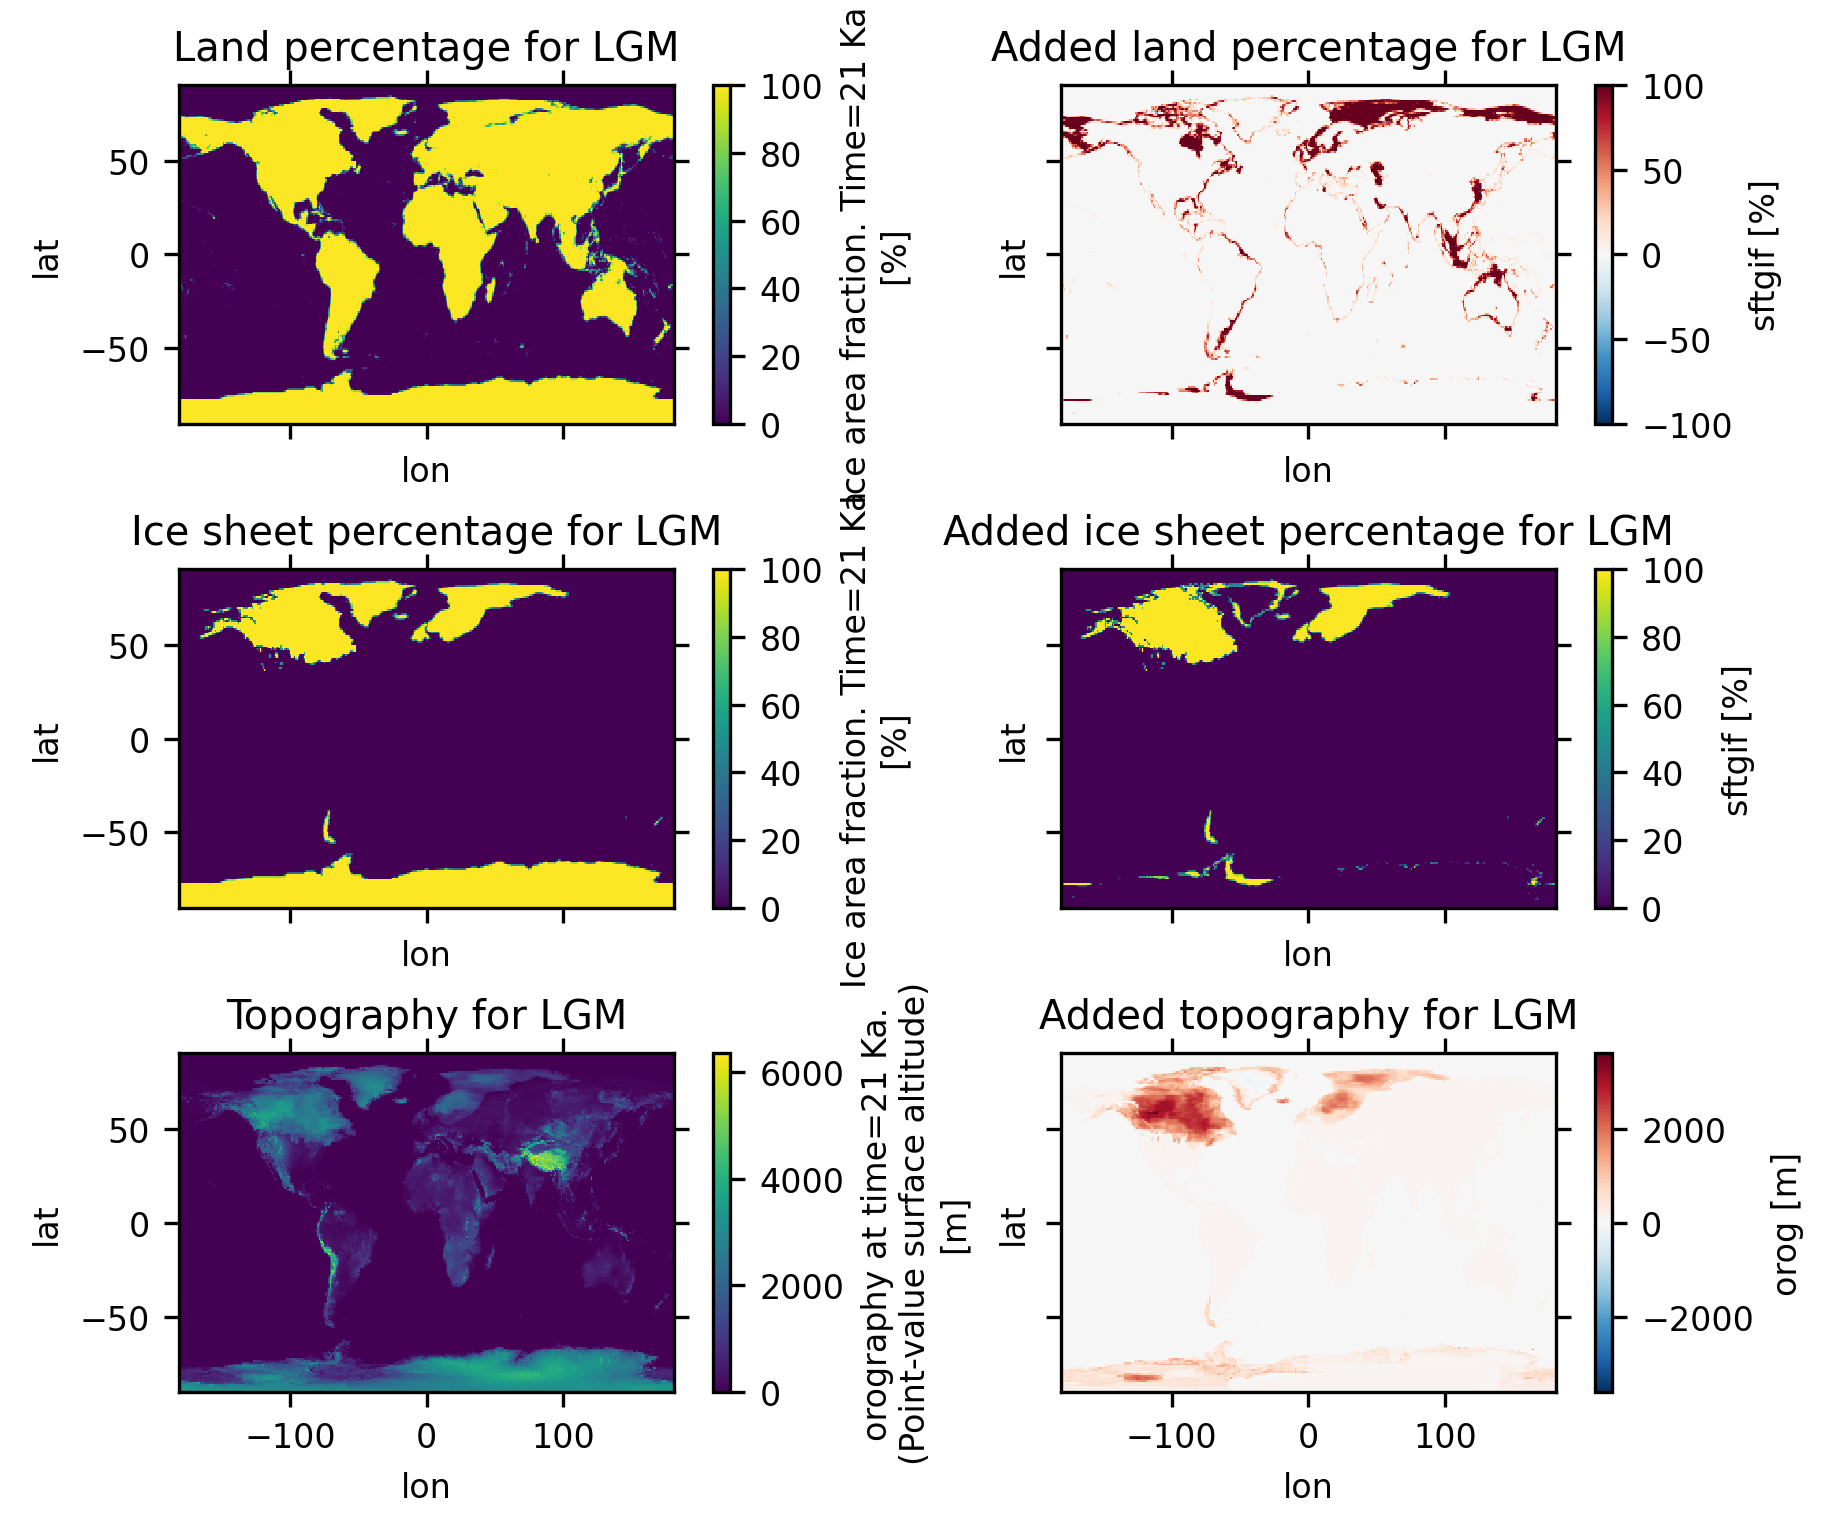

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(6, 5),
                         sharex=True, sharey=True,
                         constrained_layout=True)
axes = axes.ravel()

lnd_lgm_i6g.plot(ax=axes[0])
axes[0].set_title('Land percentage for LGM')
lnd_ano_i6g.plot(ax=axes[1])
axes[1].set_title('Added land percentage for LGM')


glc_lgm_i6g.plot(ax=axes[2])
axes[2].set_title('Ice sheet percentage for LGM')
glc_ano_i6g.plot(ax=axes[3])
axes[3].set_title('Added ice sheet percentage for LGM')

oro_lgm_i6g.plot(ax=axes[4])
axes[4].set_title('Topography for LGM')
oro_ano_i6g.plot(ax=axes[5])
axes[5].set_title('Added topography for LGM')

---
## Step 0: Create and explore the namelist files
### Create the preindustrial namelist files
- Use potential vegetation and without urban, etc.
  - e.g., `gen_mksurfdata_namelist --res 'ne30np4.pg3' --start-year 1850 --end-year 1850 --potveg_flag --nocrop`
- Check to ensure the namelist files created match those in grid_configs

In [14]:

for grid, cfg in grid_configs.items():
    subprocess.run(
        [
            f"{mksurfdata_dir}/gen_mksurfdata_namelist",
            "--res", grid,
            "--start-year", "1850",
            "--end-year", "1850",
            "--potveg_flag",
            "--nocrop",
        ],
        check=True,
        cwd=work_dir,
    )

Successfully created input namelist file surfdata_ne30np4.pg3_PtVeg_nourb_1850_16pfts_c260118.namelist
Successfully created input namelist file surfdata_ne16np4.pg3_PtVeg_nourb_1850_16pfts_c260118.namelist


### Raw files

In [15]:
cfg = next(iter(grid_configs.values()))

nml_dict = f90nml.read(cfg['pre_nml']).todict()
# nml_dict

In [16]:

raw_dict = {
    key: val
    for key, val in nml_dict['mksurfdata_input'].items()
    if not re.search("mesh", key)
}

for key in raw_dict:
    print(f"{key}: {nml_dict['mksurfdata_input'][key]}")

mksrf_flai: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/CTSM54RawData/CLM6_LUH3_HIST_CMIP7/mksrf_pftlai_clm6_histLUH3_2005_c251012.nc
mksrf_fsoicol: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/CTSM54RawData/CLM6_LUH3_HIST_CMIP7/mksrf_soilcolor_clm6_histLUH3_2005_c251012.nc
mksrf_fsoitex: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/mksrf_soil_mapunits_5x5min_WISE.c220330.nc
mksrf_fsoitex_lookup: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/mksrf_soil_lookup.10level.WISE.c220330.nc
mksrf_fmax: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/mksrf_fmax_0.125x0.125_c200220.nc
mksrf_flakdep: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/mksrf_LakePnDepth_3x3min_simyr2017_MODISgrid.cdf5.c200305.nc
mksrf_fwetlnd: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/mksrf_lanwat.050425.nc
mksrf_fvocef: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/mksrf_vocef_0.5x0.5_simyr2000.c110531.nc
mksrf_furbtopo: /glad

- `ncdump` each file and check the CTSM Tech Note (e.g., [2.2.3.3](https://escomp.github.io/CTSM/release-clm5.0/tech_note/Ecosystem/CLM50_Tech_Note_Ecosystem.html) to figure out the strategy
- Files not modified
  - mksrf_fwetlnd: wetland is no long used since CLM4.5.
  - mksrf_flakdep: safe to use PI file (no new lakes at LGM).
  - mksrf_fpeat: peat is only used in fire parameterization, which is only relevant if carbon-nitrogen cycle is on. Fire is not interactive in CTSM?
  - mksrf_fgdp: not relevant in "NoAnthro" mode.
  - mksrf_furban: not relevant in "NoAnthro" mode.
  - mksrf_fhrvtyp: not relevant in "NoAnthro" mode.
  - mksrf_fabm: “peak month for agri fire”; not relevant in NoAnthro mode.
  - mksrf_furbtopo: only screens pcturb by elevation; not relevant in NoAnthro mode.
  - mksrf_vic: Variable Infiltration Capacity (VIC) is not used
- Special files for land units
  - mksrf_fglacier: we add the glacier coverage from ICE-6G.
  - mksrf_fglacierregion: we use a new file.
  - mksrf_fvegtyp: mask vegetation with ICE-6G ice; add vegetation on exposed shelves.
  - mksrf_fpctlak: mask lakes beneath ICE-6G ice.
- Other land surface properties
  - mksrf_flai: we cover LAI/SAI with ICE-6G ice sheets and add new LAI/SAI over exposed shelves.
  - mksrf_fsoicol: we add soil under ICE-6G ice sheets and over exposed shelves.
  - mksrf_fsoitex: we add soil under ICE-6G ice sheets and over exposed shelves.
  - mksrf_fmax: we add fractional saturated area under ICE-6G ice sheets and over exposed shelves.
  - mksrf_fvocef: add isoprene emissions over exposed shelves.
  - mksrf_fsoildepth: add soil depths over exposed shelves, leaving “depth to bedrock” variables as is.
- mksrf_ftopostats: `SLOPE` is used in [Surface Water Storage](https://escomp.github.io/ctsm-docs/versions/release-clm5.0/html/tech_note/Hydrology/CLM50_Tech_Note_Hydrology.html#surface-water-storage) and `ELEVATION` is used in [Snow Covered Area Fraction](https://escomp.github.io/ctsm-docs/versions/release-clm5.0/html/tech_note/Snow_Hydrology/CLM50_Tech_Note_Snow_Hydrology.html#snow-covered-area-fraction).
  - This file is hard to work with. We can update `SLOPE` and `STD_ELEV` once we have the LGM surfdata.
  - I decide to simply using the preindustrial file, which should only have a minor effect.

### Set up LGM namelists
- The LGM namelist will be updated incrementally as new raw datasets are generated.
- All modifications are performed directly on the raw input files using their native grid; therefore, no changes to the mesh files are required.

In [17]:
for grid, cfg in grid_configs.items():

    nml_dict = f90nml.read(cfg['pre_nml']).todict()
    lgm_nml_dict = copy.deepcopy(nml_dict)

    lgm_nml_dict['mksurfdata_input']['fsurdat'] = cfg['fsurdat_out']
    lgm_nml_dict['mksurfdata_input']['fsurlog'] = cfg['fsurdat_log']
    cfg['lgm_nml_dict'] = lgm_nml_dict

grid_configs

{'ne30np4.pg3': {'pre_nml': '/glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/surfdata_ne30np4.pg3_PtVeg_nourb_1850_16pfts_c260118.namelist',
  'lgm_nml': '/glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/surfdata_ne30np4.pg3_PtVeg_nourb_1850_16pfts_21ka_c260118.namelist',
  'fsurdat_out': '/glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/surfdata_ne30np4.pg3_PtVeg_nourb_1850_16pfts_21ka_c260118.nc',
  'fsurdat_log': '/glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/surfdata_ne30np4.pg3_PtVeg_nourb_1850_16pfts_21ka_c260118.log',
  'lgm_nml_dict': OrderedDict([('mksurfdata_input',
                OrderedDict([('mksrf_fgrid_mesh',
                              '/glade/campaign/cesm/cesmdata/inputdata/share/meshes/ne30pg3_ESMFmesh_cdf5_c20211018.nc'),
                             ('mksrf_fgrid_mesh_nx', 48600),
                             ('mksrf_fgrid_mesh_ny', 1),
                             ('mksrf_flai',
                              '/glade/c

---
## Step 1: Fill raw data using nearest-neighbor interpolation
- The objective is to populate land surface properties (e.g., soil color) for newly exposed land grid points.
- The `LANDMASK` variable in the LGM raw files must be updated consistently with these changes.
- All raw files provide `LATIXY` and `LONGXY` as two-dimensional spatial coordinates, which are used for the nearest-neighbor mapping.

In [18]:
nnfill_dict = {
    'mksrf_flai': {
        'raw_file': nml_dict['mksurfdata_input']['mksrf_flai'],
        'vnames': ['MONTHLY_HEIGHT_BOT', 'MONTHLY_HEIGHT_TOP', 'MONTHLY_LAI', 'MONTHLY_SAI'],
    },
    'mksrf_fsoicol': {
        'raw_file': nml_dict['mksurfdata_input']['mksrf_fsoicol'],
        'vnames': ['SOIL_COLOR'],
    },
    'mksrf_fmax': {
        'raw_file': nml_dict['mksurfdata_input']['mksrf_fmax'],
        'vnames': ['FMAX'],
    },
    'mksrf_fvocef': {
        'raw_file': nml_dict['mksurfdata_input']['mksrf_fvocef'],
        'vnames': ['ef_btr', 'ef_crp', 'ef_fdt', 'ef_fet', 'ef_grs', 'ef_shr'],
    },
    'mksrf_fsoildepth': {
        'raw_file': nml_dict['mksurfdata_input']['mksrf_fsoildepth'],
        'vnames': ['Avg_Depth_Median', 'Avg_Depth_Mean'],
    },
    'mksrf_fsoitex': {
        # 'raw_file': nml_dict['mksurfdata_input']['mksrf_fsoitex'],
        # Use this file instead; it contains the correct LATIXY and LONGXY
        'raw_file': '/glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/mksrf_soil_mapunits_5x5min_w_latlon_WISE.c220330.nc',
        'vnames': ['MU'],
    },
}

nnfill_dict

{'mksrf_flai': {'raw_file': '/glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/CTSM54RawData/CLM6_LUH3_HIST_CMIP7/mksrf_pftlai_clm6_histLUH3_2005_c251012.nc',
  'vnames': ['MONTHLY_HEIGHT_BOT',
   'MONTHLY_HEIGHT_TOP',
   'MONTHLY_LAI',
   'MONTHLY_SAI']},
 'mksrf_fsoicol': {'raw_file': '/glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/CTSM54RawData/CLM6_LUH3_HIST_CMIP7/mksrf_soilcolor_clm6_histLUH3_2005_c251012.nc',
  'vnames': ['SOIL_COLOR']},
 'mksrf_fmax': {'raw_file': '/glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/mksrf_fmax_0.125x0.125_c200220.nc',
  'vnames': ['FMAX']},
 'mksrf_fvocef': {'raw_file': '/glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/mksrf_vocef_0.5x0.5_simyr2000.c110531.nc',
  'vnames': ['ef_btr', 'ef_crp', 'ef_fdt', 'ef_fet', 'ef_grs', 'ef_shr']},
 'mksrf_fsoildepth': {'raw_file': '/glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/mksf_soilthk_5x5min_ORNL-Soil_simyr1900-2015_c170630.nc',
  'vnames': ['Avg_Depth_Median', '

- The following cell runs slow and you could change it to `raw` to test the other parts of the notebook

In [19]:
%%time

# for key in ['mksrf_flai']:
#     case = nnfill_dict[key]

# for key in ['mksrf_fsoitex']:
#     case = nnfill_dict[key]

# for key in ['mksrf_fmax']:
#     case = nnfill_dict[key]

# for key in ['mksrf_fsoicol']:
#     case = nnfill_dict[key]

# for key in ['mksrf_fsoildepth']:
#     case = nnfill_dict[key]

for key, case in nnfill_dict.items():

    # Figure out the input and output file names
    raw_file = case['raw_file']

    fname = Path(Path(raw_file).name)
    lgm_raw_file = f"{work_dir}/{fname.stem}_21ka_nnfilled{fname.suffix}"

    case['lgm_raw_file'] = lgm_raw_file

    ds = xr.open_dataset(raw_file)

    print(f"{key}")
    print(f"  Input     : {raw_file}")
    print(f"  Output    : {lgm_raw_file}")
    print(f"  All vars  : {list(ds.data_vars)}")
    print(f"  Fill these: {case['vnames']}")
    print(f"  Lon range : {ds.LONGXY.min():.2f} to {ds.LONGXY.max():.2f}")

    # Mask each variable first and then fill nans with nearest neighbor
    for vname in case['vnames']:

        # Soiltex file does not have a land mask
        if vname == 'MU':
            ds['LANDMASK'] = xr.where(ds.MU > 0, 1, 0).astype(int)

        var_masked = ds[vname].where(ds.LANDMASK > 0)
  
        lon_dim, lat_dim = infer_lon_lat_dims(var_masked)
        filled = fill_na(var_masked, lon_dim, lat_dim)

        if vname == "MU":
            filled = filled.astype("int32")
            filled.encoding["_FillValue"] = -9999
        ds[vname] = filled

    # Interpolate ICE-6G onto this raw-file grid (handles 0–360 → [-180, 180))
    lnd_ano_i6g_interp = interp_i6g_to(ds, lnd_ano_i6g)
    lnd_lgm_i6g_interp = interp_i6g_to(ds, lnd_lgm_i6g)

    has_new_lnd = lnd_ano_i6g_interp > pct_tol
    is_full_lnd = lnd_lgm_i6g_interp >= (100.0 - pct_tol)

    # Update LANDFRAC and LANDMASK in the dataset
    if "LANDFRAC" in ds.data_vars:
        print(f"  Update both LANDFRAC and LANDMASK\n")

        # 1) Apply land anomaly where new land appears
        ds['LANDFRAC'] = ds['LANDFRAC'].where(
            ~has_new_lnd,
            ds["LANDFRAC"] + lnd_ano_i6g_interp / 100.
        ).clip(min=0.0, max=1.0)

        # 2) Enforce full land where ICE-6G says essentially 100% land
        # This removes spurious partial-ocean bands along PI coastlines, which likely
        # arises from data inconsistencies and the coarse spatial resolution of ICE-6G.
        ds["LANDFRAC"] = ds["LANDFRAC"].where(~is_full_lnd, 1.0)

        # 3) Keep LANDMASK consistent with LANDFRAC
        ds['LANDMASK'] = (ds.LANDFRAC > 0).astype(ds.LANDMASK.dtype)

    else:
        print(f"  Update LANDMASK\n")
  
        ds["LANDMASK"] = ds["LANDMASK"].where(
            ~(has_new_lnd | is_full_lnd),
            1,
        ).astype(ds["LANDMASK"].dtype)
        
    # Loop over grids and update the raw file in the namelist
    for grid, cfg in grid_configs.items():
        cfg['lgm_nml_dict']['mksurfdata_input'][key] = lgm_raw_file

    # Save data
    ds.to_netcdf(lgm_raw_file)
    ds.close()
    subprocess.run(['ncks', "-hO5", lgm_raw_file, lgm_raw_file])

mksrf_flai
  Input     : /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/CTSM54RawData/CLM6_LUH3_HIST_CMIP7/mksrf_pftlai_clm6_histLUH3_2005_c251012.nc
  Output    : /glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/mksrf_pftlai_clm6_histLUH3_2005_c251012_21ka_nnfilled.nc
  All vars  : ['AREA', 'EDGEE', 'EDGEN', 'EDGES', 'EDGEW', 'LANDFRAC', 'LANDMASK', 'LAT', 'LATIXY', 'LON', 'LONGXY', 'MONTHLY_HEIGHT_BOT', 'MONTHLY_HEIGHT_TOP', 'MONTHLY_LAI', 'MONTHLY_SAI']
  Fill these: ['MONTHLY_HEIGHT_BOT', 'MONTHLY_HEIGHT_TOP', 'MONTHLY_LAI', 'MONTHLY_SAI']
  Lon range : -179.88 to 179.88
  Update both LANDFRAC and LANDMASK

mksrf_fsoicol
  Input     : /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/CTSM54RawData/CLM6_LUH3_HIST_CMIP7/mksrf_soilcolor_clm6_histLUH3_2005_c251012.nc
  Output    : /glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/mksrf_soilcolor_clm6_histLUH3_2005_c251012_21ka_nnfilled.nc
  All vars  : ['AREA', 'EDGEE', 'EDGEN', 'EDGES', 'EDGEW', 'LA

### Make plots to check results
- For simplicity, I compute and plot 2D fields (mean over non-lat and non-lon dimensions)
- Examine the "new land grid points" such as the Sunda Shelf in the Warm Pool. Do you see meaningful values?

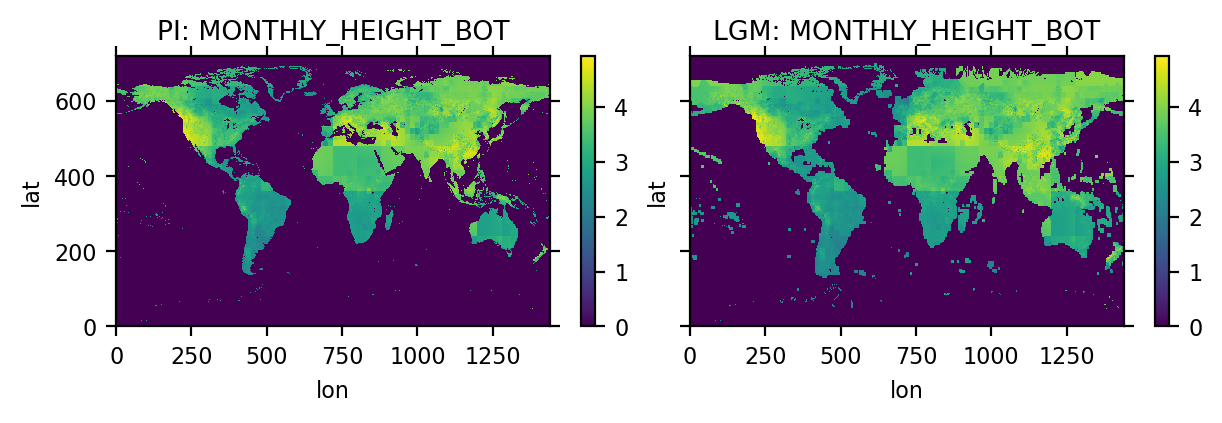

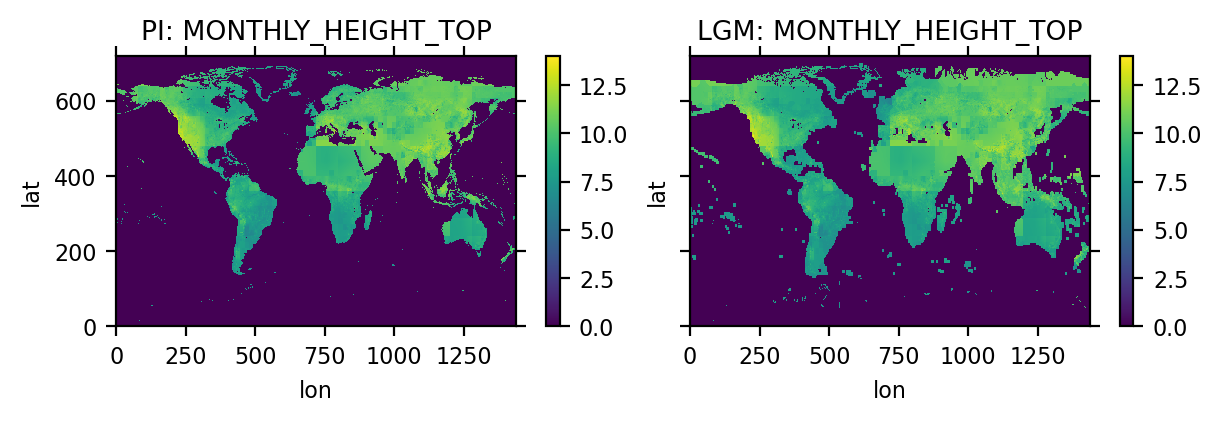

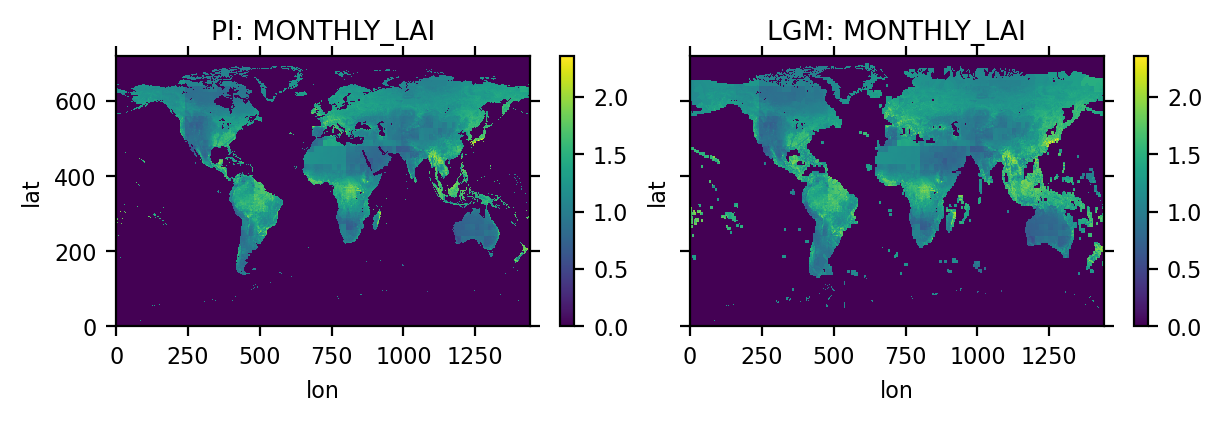

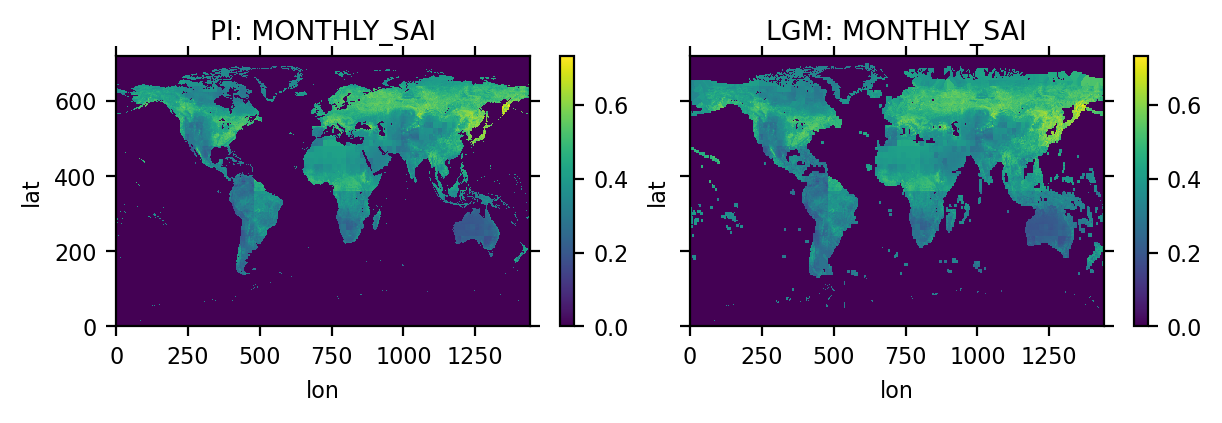

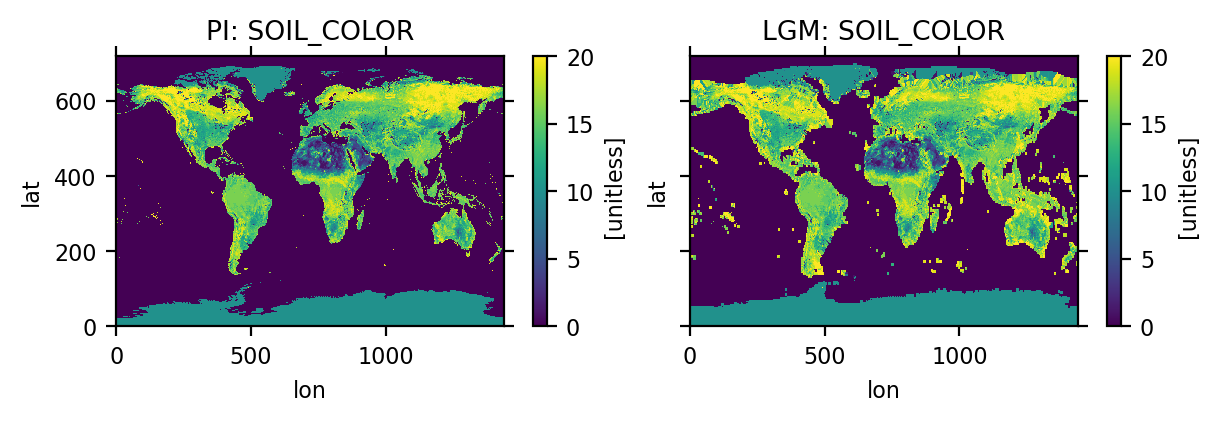

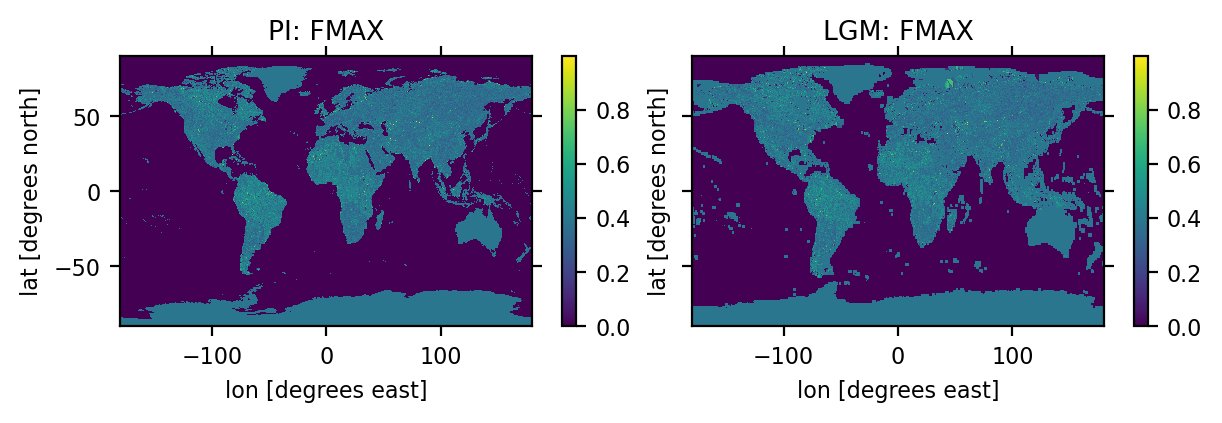

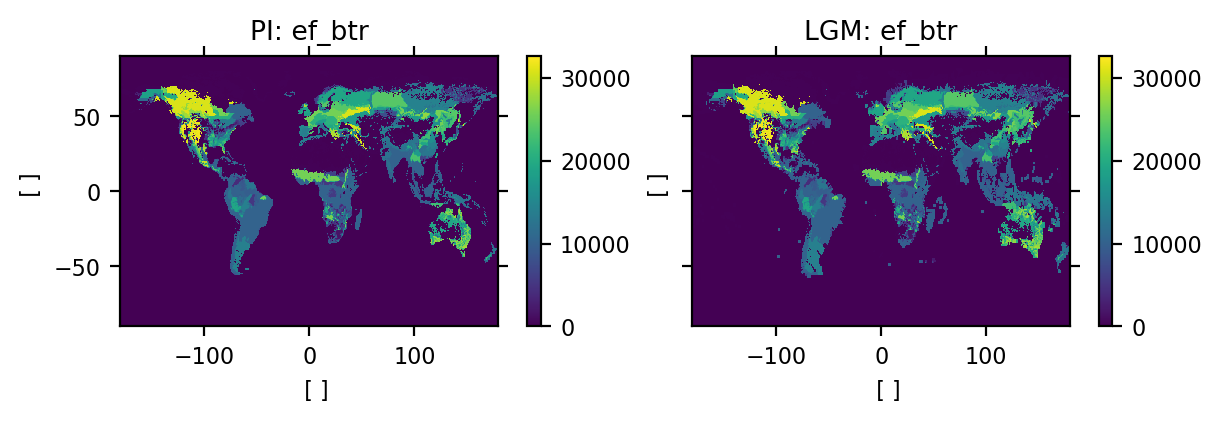

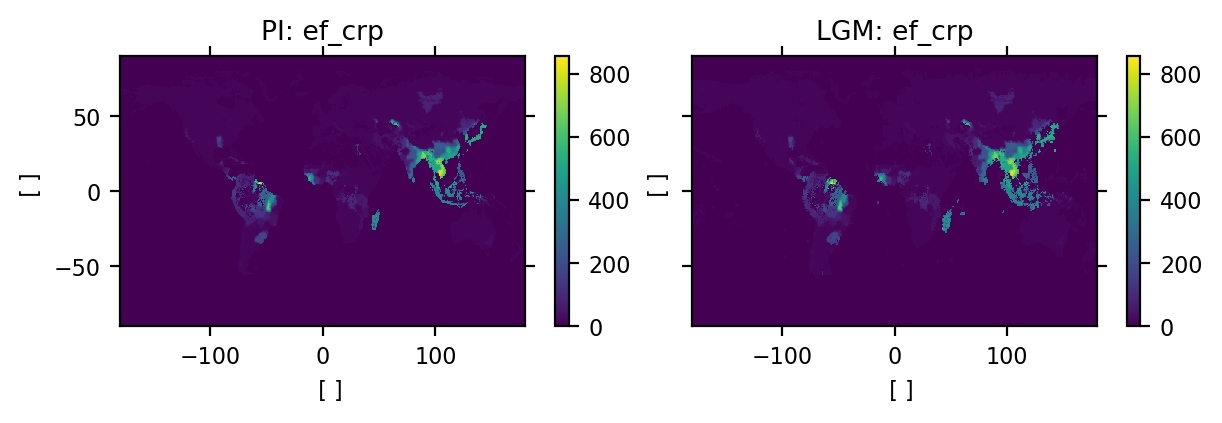

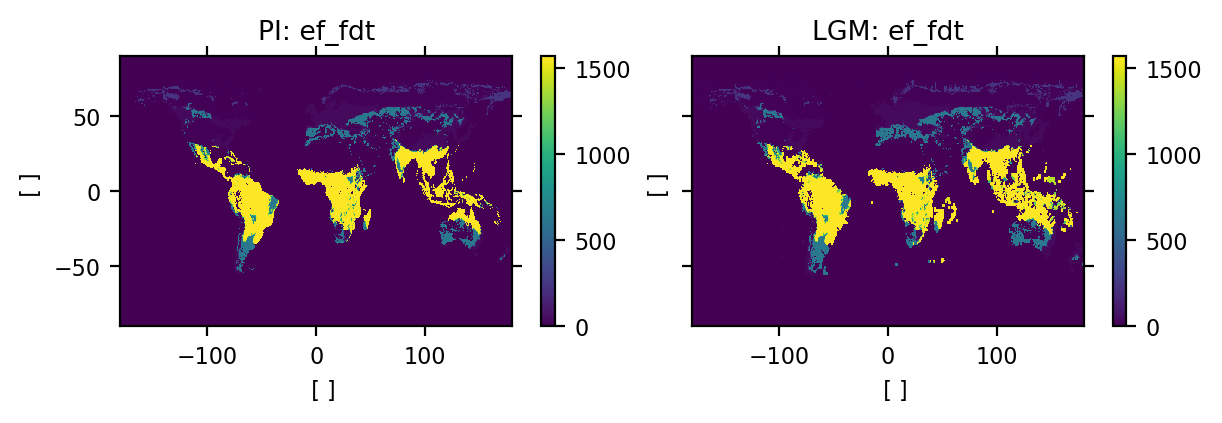

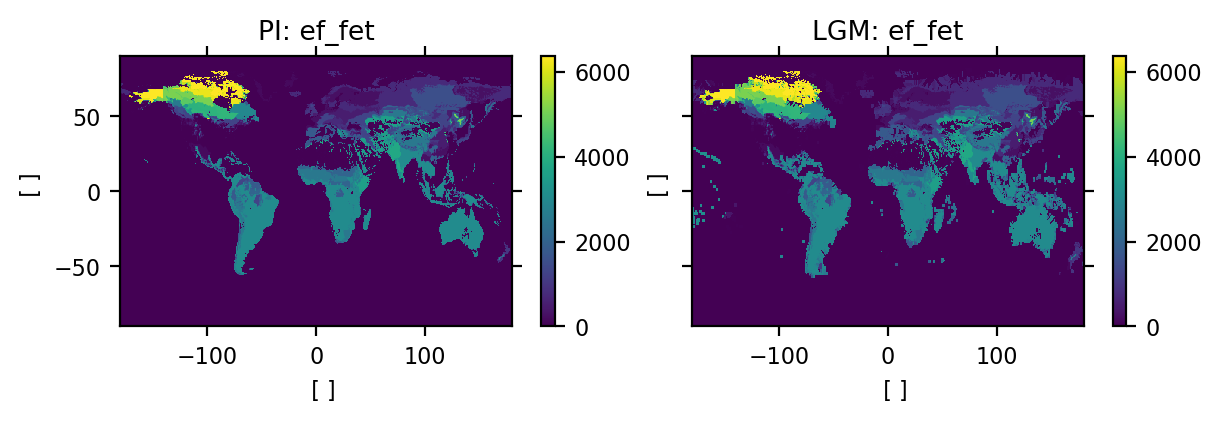

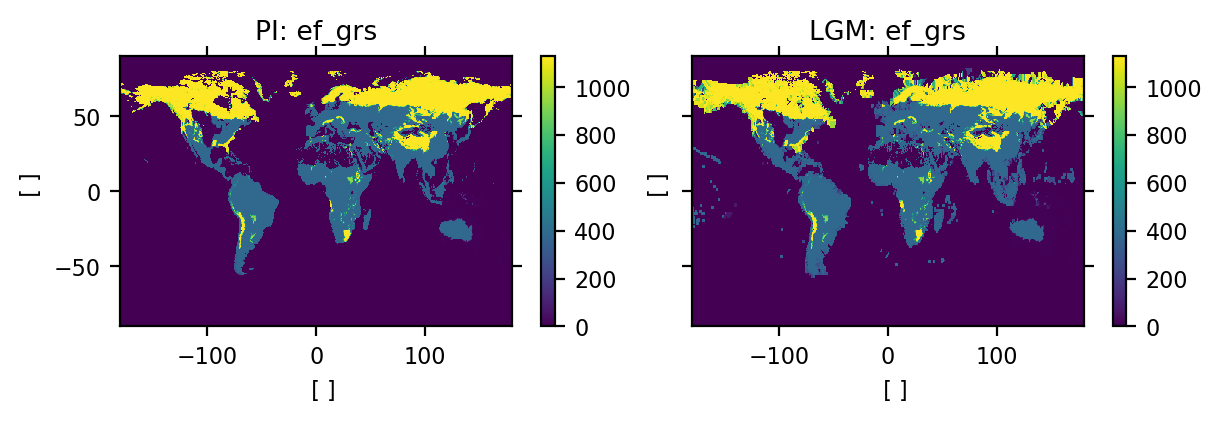

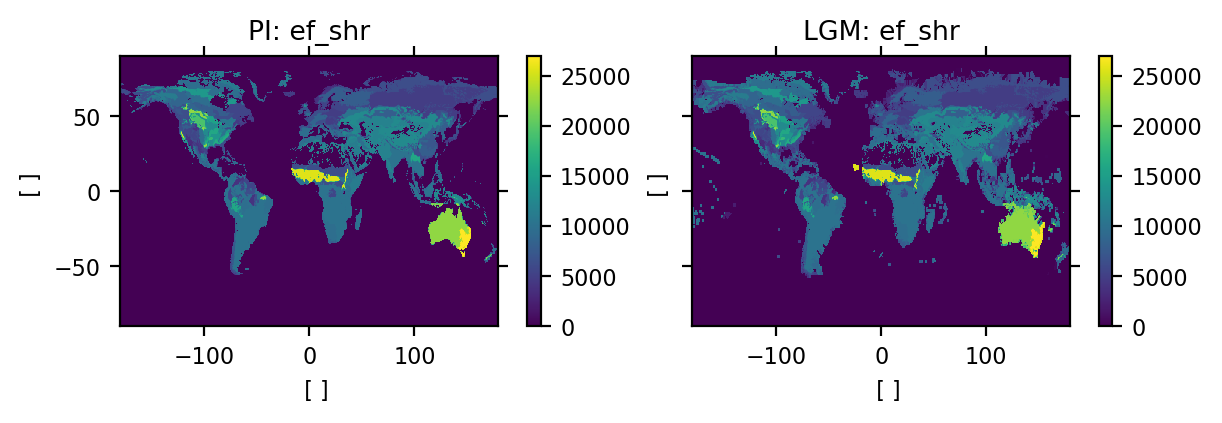

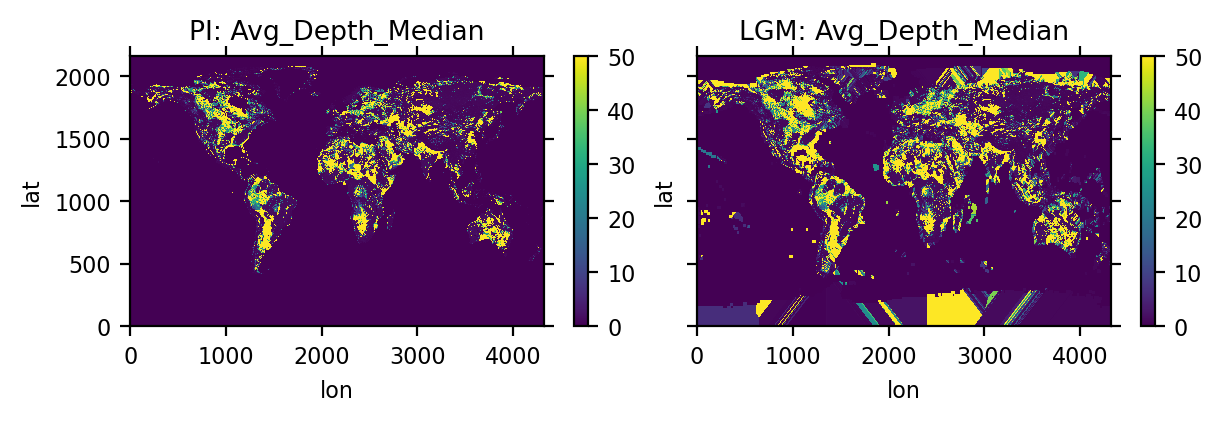

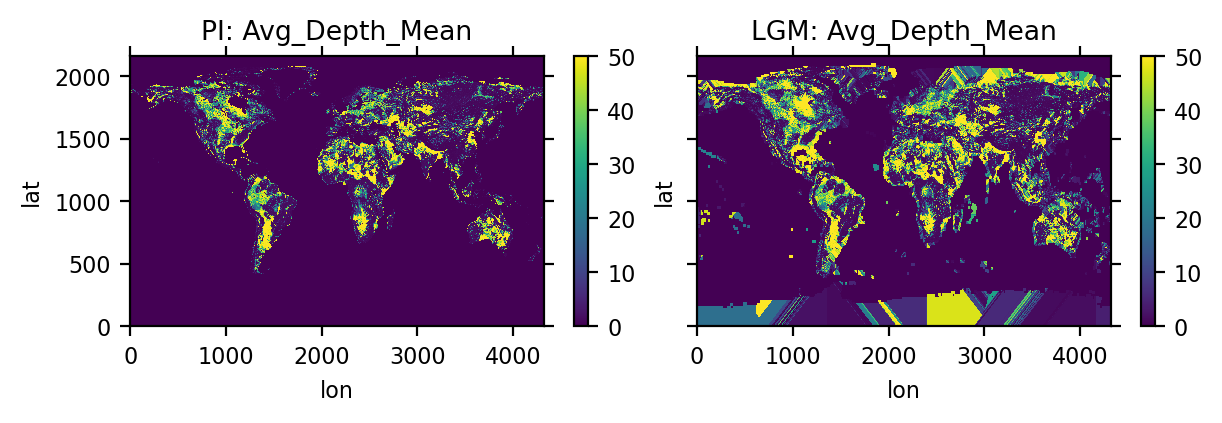

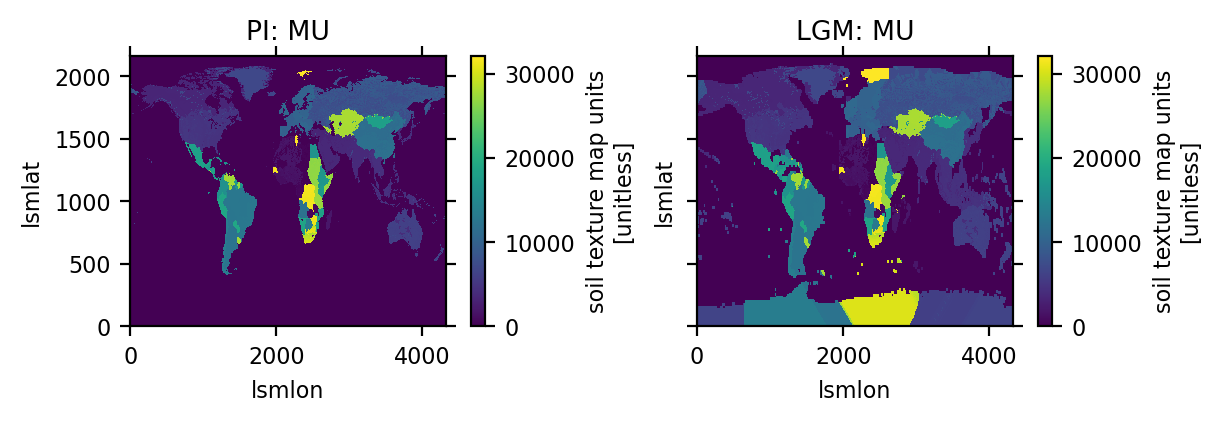

In [20]:
# for key in ['mksrf_flai']:
#     case = nnfill_dict[key]

for key, case in nnfill_dict.items():

    ds = xr.open_dataset(case['raw_file'])
    ds_lgm = xr.open_dataset(case['lgm_raw_file'])

    for vname in case['vnames']:
        fig, axes = plt.subplots(
            1, 2, figsize=(6, 2), dpi=200, sharex=True, sharey=True,
            constrained_layout=True)

        # Soiltex file does not have a land mask
        if vname == 'MU':
            lmask = xr.where(ds.MU > 0, 1, 0)
        else:
            lmask = ds.LANDMASK

        lmask_lgm = ds_lgm.LANDMASK

        var = (ds[vname] * lmask)
        lon_dim, lat_dim = infer_lon_lat_dims(var)
        var.sortby(lon_dim).mean(
            dim=[dim for dim in ds.dims if dim not in [
                lon_dim, lat_dim]]).plot(ax=axes[0])
        axes[0].set_title(f"PI: {vname}")

        var_lgm = (ds_lgm[vname] * lmask_lgm)
        var_lgm.sortby(lon_dim).mean(
            dim=[dim for dim in ds.dims if dim not in [
                lon_dim, lat_dim]]).plot(ax=axes[1])
        axes[1].set_title(f"LGM: {vname}")

    ds.close()
    ds_lgm.close()

---
## Step 2: Remove lakes underneath the LGM ice sheets
- `LANDMASK` in the lake file is also updated

In [21]:
pctlak_file = nml_dict['mksurfdata_input']['mksrf_fpctlak']

fname = Path(Path(pctlak_file).name)
lgm_pctlak_file = f"{work_dir}/{fname.stem}_21ka{fname.suffix}"

print(f"Input : {pctlak_file}")
print(f"Output: {lgm_pctlak_file}")

ds_pctlak = xr.open_dataset(pctlak_file)
ds_pctlak_lgm = ds_pctlak.copy(deep=True)

print(f"Lon range: {ds_pctlak.lon.min():.2f} to {ds_pctlak.lon.max():.2f}")

ds_pctlak

Input : /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/lake_area/mksurf_lake_0.05x0.05_hist_clm5_hydrolakes_1850.cdf5.c20220325.nc
Output: /glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/mksurf_lake_0.05x0.05_hist_clm5_hydrolakes_1850.cdf5.c20220325_21ka.nc
Lon range: -179.97 to 179.98


<xarray.Dataset> Size: 830MB
Dimensions:   (lat: 3600, lon: 7200)
Coordinates:
  * lat       (lat) float64 29kB -89.97 -89.92 -89.88 ... 89.87 89.92 89.97
  * lon       (lon) float64 58kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Data variables:
    PCT_LAKE  (lat, lon) float64 207MB ...
    LANDMASK  (lat, lon) float64 207MB ...
    LATIXY    (lat, lon) float64 207MB ...
    LONGXY    (lat, lon) float64 207MB ...
Attributes:
    source:         HydroLAKES polygons dataset v1.0 June 2019
    title:          Percent Lake calculated from the Hydrolakes dataset mappe...
    references:     Messager, M.L., Lehner, B., Grill, G., Nedeva, I., Schmit...
    url:            https://www.hydrosheds.org/pages/hydrolakes
    creation_date:  Thu Mar  5 13:41:39 2020

### Remove lakes underneath ice sheets, save output and update the LGM namelist
- We need to regrid the ICE-6G land fraction and glacier coverage into the grid of lake file

In [22]:

# Interpolate ICE-6G
glc_ano_i6g_interp = interp_i6g_to(ds_pctlak, glc_ano_i6g)
lnd_ano_i6g_interp = interp_i6g_to(ds_pctlak, lnd_ano_i6g)
lnd_lgm_i6g_interp = interp_i6g_to(ds_pctlak, lnd_lgm_i6g)

has_new_lnd = lnd_ano_i6g_interp > pct_tol
has_new_glc = glc_ano_i6g_interp > pct_tol
is_full_lnd = lnd_lgm_i6g_interp >= (100.0 - pct_tol)

# Remove lakes
ds_pctlak_lgm['PCT_LAKE'] = ds_pctlak['PCT_LAKE'].where(
    ~has_new_glc,
    ds_pctlak['PCT_LAKE'] - glc_ano_i6g_interp
).clip(max=100.0, min=0.0)

# Update LANDMASK
ds_pctlak_lgm["LANDMASK"] = ds_pctlak["LANDMASK"].where(
    ~(has_new_lnd | is_full_lnd),
    1
).astype(ds_pctlak["LANDMASK"].dtype)

# Save the LGM file
ds_pctlak_lgm.to_netcdf(lgm_pctlak_file)
subprocess.run(['ncks', "-hO5", lgm_pctlak_file, lgm_pctlak_file])

# Loop over grids and update the raw file in the namelist
for grid, cfg in grid_configs.items():
    cfg['lgm_nml_dict']['mksurfdata_input']['mksrf_fpctlak'] = lgm_pctlak_file

### Make plot to check results

Text(0.5, 1.0, 'LGM Changes')

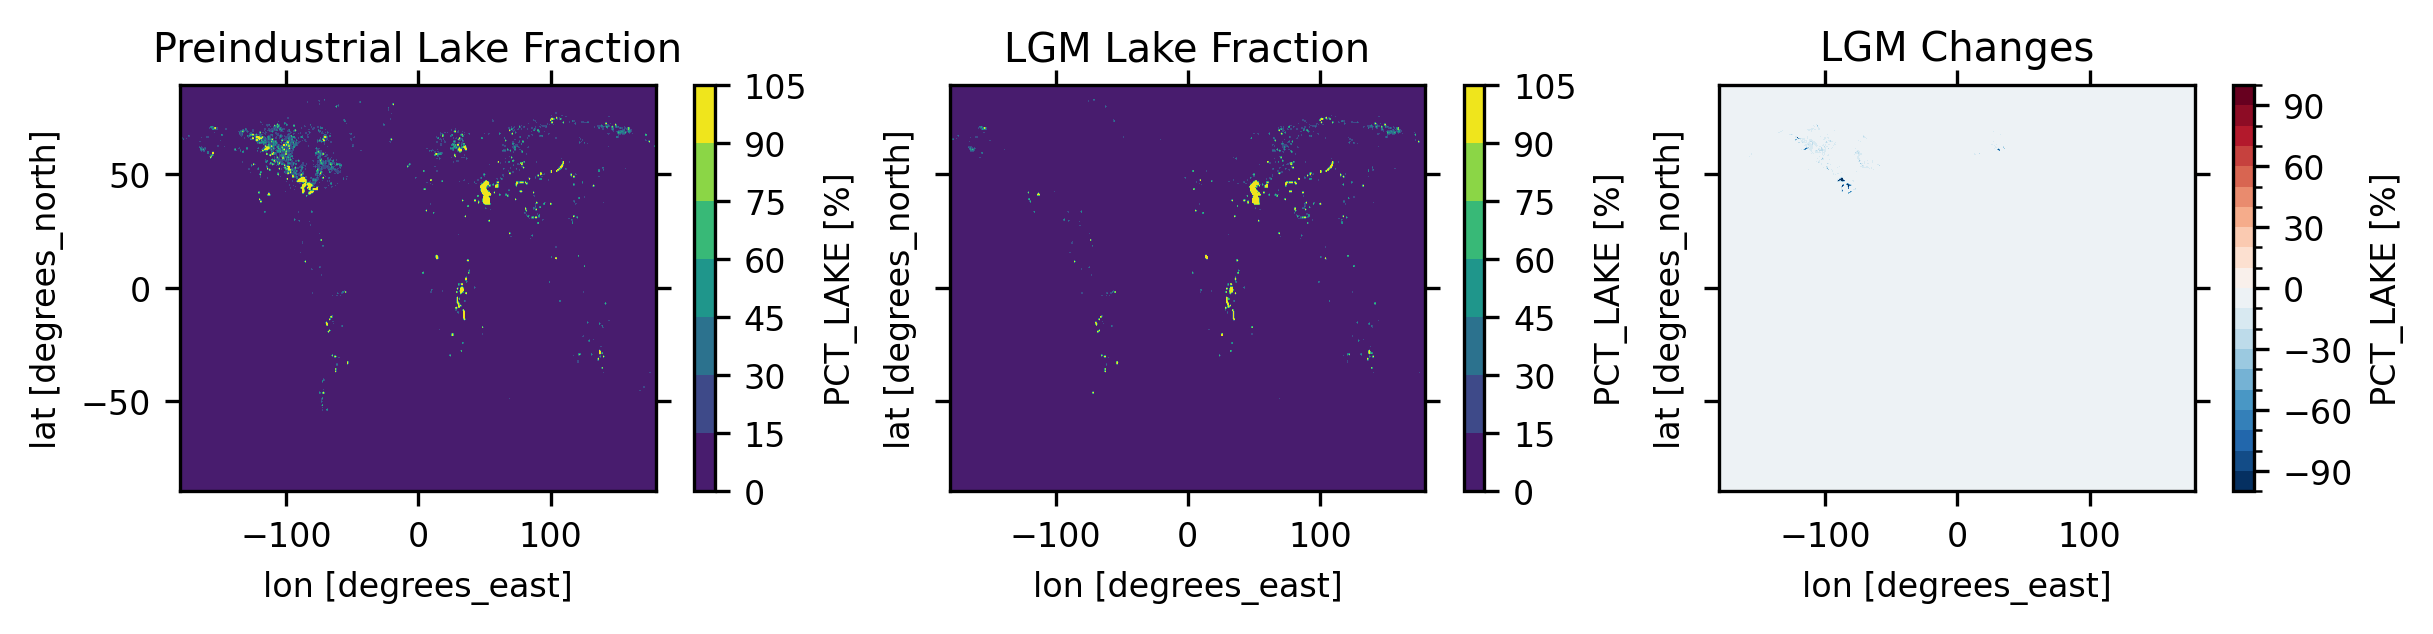

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(8, 2),
                         sharex=True, sharey=True,
                         constrained_layout=True)

ds_pctlak.PCT_LAKE.thin(10).plot.contourf(
    ax=axes[0])
axes[0].set_title('Preindustrial Lake Fraction')

ds_pctlak_lgm.PCT_LAKE.thin(10).plot.contourf(
    ax=axes[1])
axes[1].set_title('LGM Lake Fraction')

(ds_pctlak_lgm - ds_pctlak).PCT_LAKE.thin(10).plot.contourf(
    ax=axes[2], cmap='RdBu_r', levels=np.linspace(-100, 100, 21))
axes[2].set_title('LGM Changes')

In [24]:
# Free up memory
ds_pctlak.close()
ds_pctlak_lgm.close()

for var in ['lnd_lgm_i6g_interp', 'lnd_ano_i6g_interp',
            'lnd_lgm_i6g_interp', 'glc_ano_i6g_interp']:
    if var in globals():
        del globals()[var]

---
## Step 3: Add PFTs over new LGM land points and remove PFTs underneath LGM ice sheets

In [25]:
pft_file = nml_dict['mksurfdata_input']['mksrf_fvegtyp']

fname = Path(Path(pft_file).name)
lgm_pft_file = f"{work_dir}/{fname.stem}_21ka{fname.suffix}"

print(f"Input : {pft_file}")
print(f"Output: {lgm_pft_file}")

ds_pft = xr.open_dataset(pft_file)
ds_pft_lgm = ds_pft.copy(deep=True)

print(f"Lon range: {ds_pft.LONGXY.min():.2f} to {ds_pft.LONGXY.max():.2f}")

ds_pft

Input : /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/CTSM54RawData/CLM6_LUH3_NOANTHRO_CMIP7/mksrf_landuse_clm6_noanthroLUH3_1.c251012.nc
Output: /glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/mksrf_landuse_clm6_noanthroLUH3_1.c251012_21ka.nc
Lon range: -179.88 to 179.88


<xarray.Dataset> Size: 2GB
Dimensions:                  (lat: 720, lon: 1440, natpft: 15, cft: 64)
Coordinates:
  * natpft                   (natpft) int32 60B 0 1 2 3 4 5 ... 9 10 11 12 13 14
  * cft                      (cft) int32 256B 15 16 17 18 19 ... 74 75 76 77 78
Dimensions without coordinates: lat, lon
Data variables: (12/28)
    EDGEN                    float32 4B ...
    EDGEE                    float32 4B ...
    EDGES                    float32 4B ...
    EDGEW                    float32 4B ...
    LAT                      (lat) float32 3kB ...
    LATIXY                   (lat, lon) float32 4MB ...
    ...                       ...
    HARVEST_SH1              (lat, lon) float64 8MB ...
    HARVEST_SH2              (lat, lon) float64 8MB ...
    HARVEST_SH3              (lat, lon) float64 8MB ...
    GRAZING                  (lat, lon) float64 8MB ...
    UNREPRESENTED_PFT_LULCC  (natpft, lat, lon) float64 124MB ...
    UNREPRESENTED_CFT_LULCC  (cft, lat, lon) float64 531MB ...
Attributes: (12/16)
    Conventions:        NCAR-CSM
    Author:             Peter Lawrence, lawrence@ucar.edu, NCAR, Terrestrial ...
    History_Log:        c251012
    Region:             /glade/campaign/cesm/development/lmwg/clm6landusedata...
    ctsmLUHprimfDB:     /glade/campaign/cesm/development/lmwg/clm6landusedata...
    CTSMSecdFDB:        /glade/campaign/cesm/development/lmwg/clm6landusedata...
    ...                 ...
    CTSMC3PerDB:        /glade/campaign/cesm/development/lmwg/clm6landusedata...
    CTSMC4PerDB:        /glade/campaign/cesm/development/lmwg/clm6landusedata...
    CTSMC3NfxDB:        /glade/campaign/cesm/development/lmwg/clm6landusedata...
    LUH2StatesDB:       /glade/campaign/cesm/development/lmwg/clm6landusedata...
    LUH2ManagementDB:   /glade/campaign/cesm/development/lmwg/clm6landusedata...
    LUH2TransitionsDB:  /glade/campaign/cesm/development/lmwg/clm6landusedata...

### Update`LANDFRAC` and `LANDMASK` in the LGM pft file and make plots
- `LANDFRAC` in mksrf_fvegtyp is used as land fraction for the entire surfdata?
- `LANDMASK`, when mutiplied by 100, is the same as `PCT_NAT_PFT.sum('natpft')` to round-off error

Text(0.5, 1.0, '$\\Delta$LANDMASK')

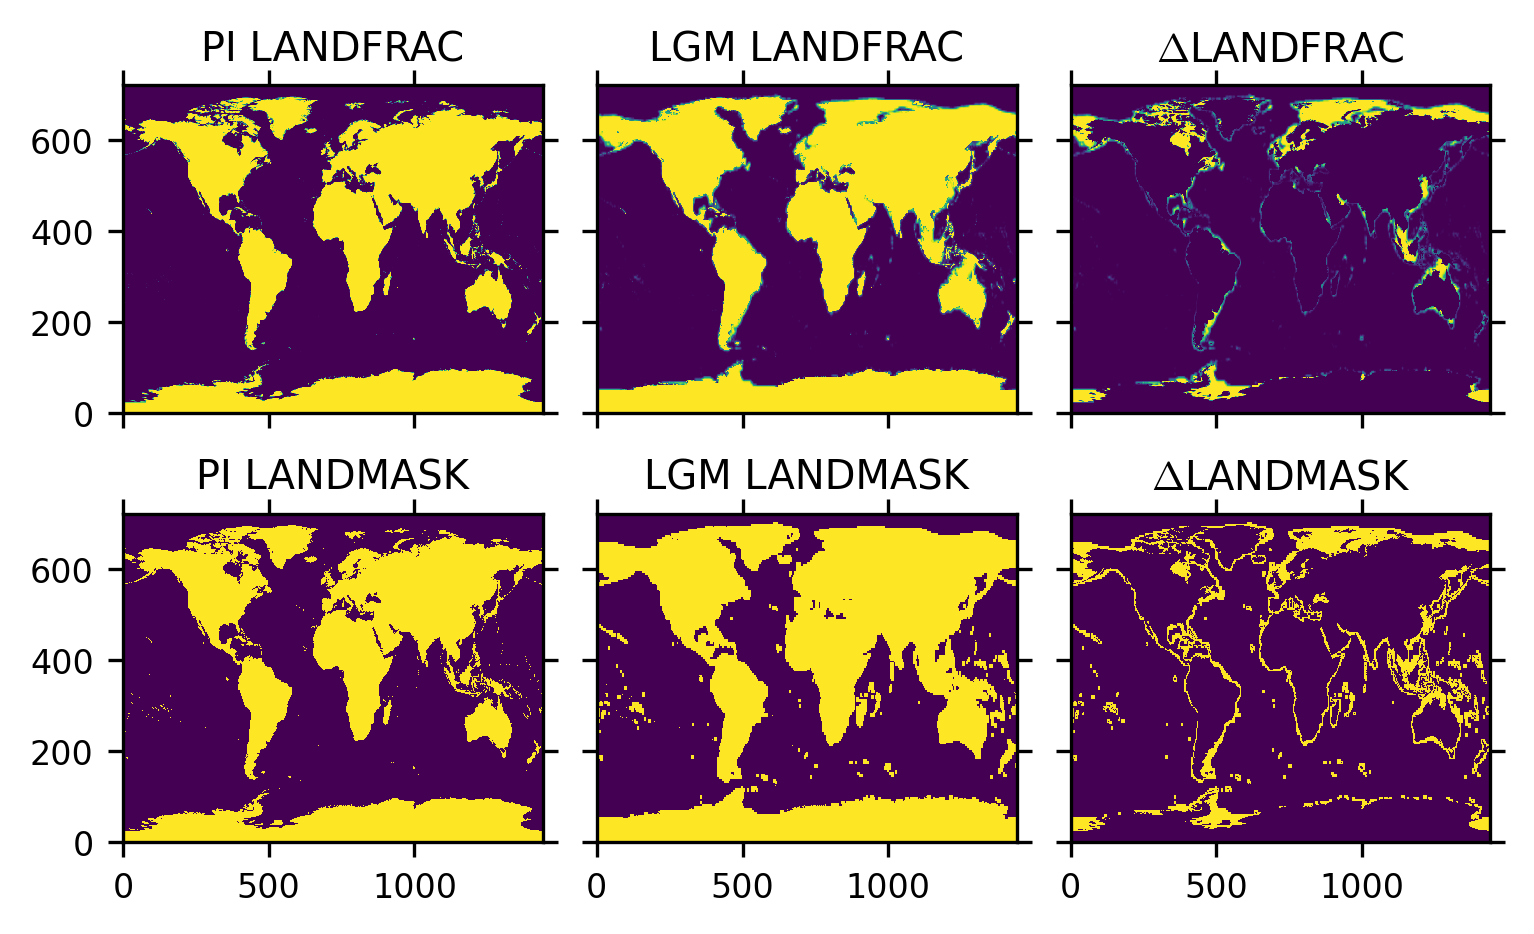

In [26]:
# Interpolate ICE-6G
glc_lgm_i6g_interp = interp_i6g_to(ds_pft, glc_lgm_i6g)
lnd_lgm_i6g_interp = interp_i6g_to(ds_pft, lnd_lgm_i6g)
lnd_ano_i6g_interp = interp_i6g_to(ds_pft, lnd_ano_i6g)

has_new_lnd = lnd_ano_i6g_interp > pct_tol
has_lgm_glc = glc_lgm_i6g_interp > pct_tol
is_full_lnd = lnd_lgm_i6g_interp >= (100.0 - pct_tol)
is_full_glc = glc_lgm_i6g_interp >= (100.0 - pct_tol)

# Update LANDFRAC (fraction 0–1); lnd_ano_i6g_interp is percent (0–100)
ds_pft_lgm["LANDFRAC"] = ds_pft_lgm["LANDFRAC"].where(
    ~has_new_lnd,
    ds_pft_lgm["LANDFRAC"] + lnd_ano_i6g_interp.clip(min=0.0) / 100.0,
).clip(min=0.0, max=1.0)

# Enforce full land where ICE-6G says essentially 100% land
ds_pft_lgm["LANDFRAC"] = ds_pft_lgm["LANDFRAC"].where(
    ~is_full_lnd,
    1.0,
).astype(ds_pft["LANDFRAC"].dtype)

# Update LANDMASK
ds_pft_lgm["LANDMASK"] = (ds_pft_lgm["LANDFRAC"] > 0).astype(ds_pft["LANDMASK"].dtype)

# Make plots
fig, axes = plt.subplots(2, 3, figsize=(5, 3),
                         sharex=True, sharey=True,
                         constrained_layout=True)
axes = axes.ravel()

ax = axes[0]
ax.pcolormesh(ds_pft.LANDFRAC)
ax.set_title('PI LANDFRAC')

ax = axes[1]
ax.pcolormesh(ds_pft_lgm.LANDFRAC)
ax.set_title('LGM LANDFRAC')

ax = axes[2]
ax.pcolormesh((ds_pft_lgm - ds_pft).LANDFRAC)
ax.set_title('$\Delta$LANDFRAC')

ax = axes[3]
ax.pcolormesh(ds_pft.LANDMASK)
ax.set_title('PI LANDMASK')

ax = axes[4]
ax.pcolormesh(ds_pft_lgm.LANDMASK)
ax.set_title('LGM LANDMASK')

ax = axes[5]
ax.pcolormesh(ds_pft_lgm.LANDMASK - ds_pft.LANDMASK)
ax.set_title('$\Delta$LANDMASK')

### Add `PCT_NATVEG` to cover the LGM new land cells
- In `mksrf_fvegtyp`, `PCT_NATVEG + PCT_LAKE + PCT_GLACIER` approximately equals `LANDFRAC * 100` (closure error ≤ 0.01%).
- Newly exposed LGM land is assigned to vegetated land units.
- PFTs covered by newly prescribed glacier extent are subsequently removed to maintain consistency.

In [27]:
(ds_pft.PCT_NATVEG + ds_pft.PCT_LAKE + ds_pft.PCT_GLACIER - ds_pft.LANDFRAC*100).hvplot.image()

:Image   [lon,lat]   (value)

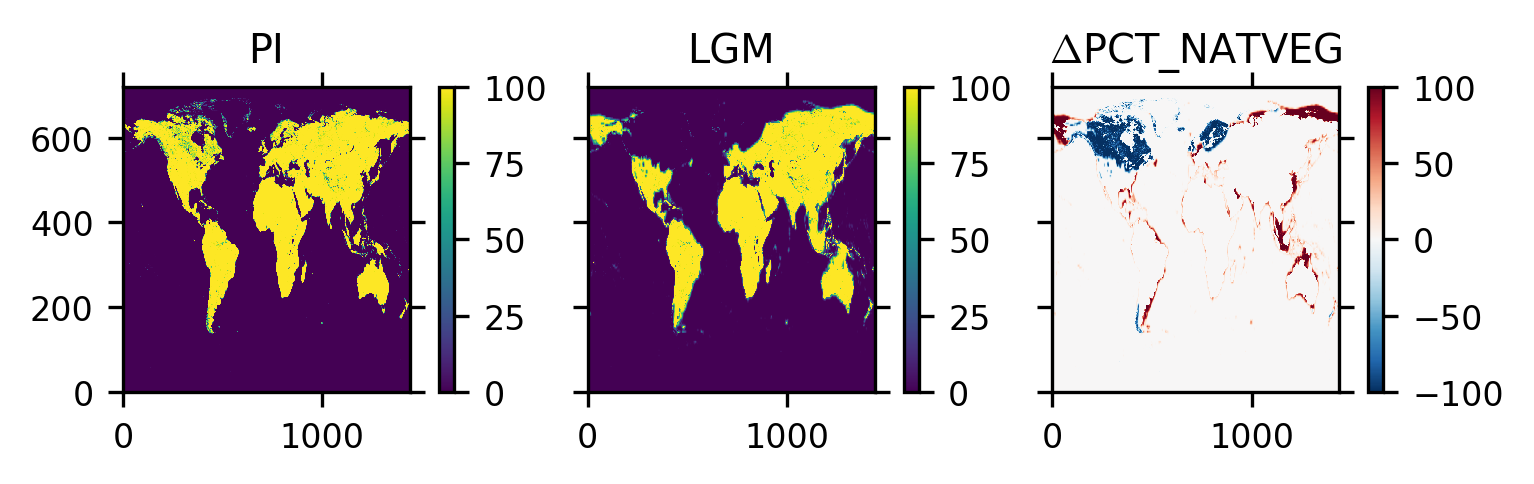

In [28]:
# Make new land cells as vegetated
ds_pft_lgm['PCT_NATVEG'] = ds_pft.PCT_NATVEG + \
    (ds_pft_lgm.LANDFRAC - ds_pft.LANDFRAC) * 100.0

# Remove LGM ice-sheet-covered area from natural vegetation
ds_pft_lgm['PCT_NATVEG'] = ds_pft_lgm['PCT_NATVEG'].where(
    ~has_lgm_glc,
    ds_pft_lgm.PCT_NATVEG - glc_lgm_i6g_interp
).clip(min=0.0, max=100.0)

fig, axes = plt.subplots(1, 3, figsize=(5, 1.5),
                         sharex=True, sharey=True,
                         constrained_layout=True)
axes = axes.ravel()

ax = axes[0]
pcm = ax.pcolormesh(ds_pft.PCT_NATVEG)
ax.set_title('PI')
plt.colorbar(pcm)

ax = axes[1]
pcm = ax.pcolormesh(ds_pft_lgm.PCT_NATVEG)
ax.set_title('LGM')
plt.colorbar(pcm)

ax = axes[2]
pcm = ax.pcolormesh((ds_pft_lgm.PCT_NATVEG - ds_pft.PCT_NATVEG), cmap='RdBu_r')
ax.set_title('$\Delta$PCT_NATVEG')
plt.colorbar(pcm)

### Add PFTs to `PCT_NAT_PFT` with nearest neighbor

In [29]:
pct_nat_pft_masked = ds_pft_lgm['PCT_NAT_PFT'].where(ds_pft['LANDMASK'] > 0)

ds_pft_lgm['PCT_NAT_PFT'] = fill_na(pct_nat_pft_masked, 'lon', 'lat')

### Save the LGM PFT file and update the namelist

In [30]:
ds_pft_lgm.to_netcdf(lgm_pft_file)
subprocess.run(['ncks', "-hO5", lgm_pft_file, lgm_pft_file])

for grid, cfg in grid_configs.items():
    cfg['lgm_nml_dict']['mksurfdata_input']['mksrf_fvegtyp'] = lgm_pft_file

### Make plots to check results

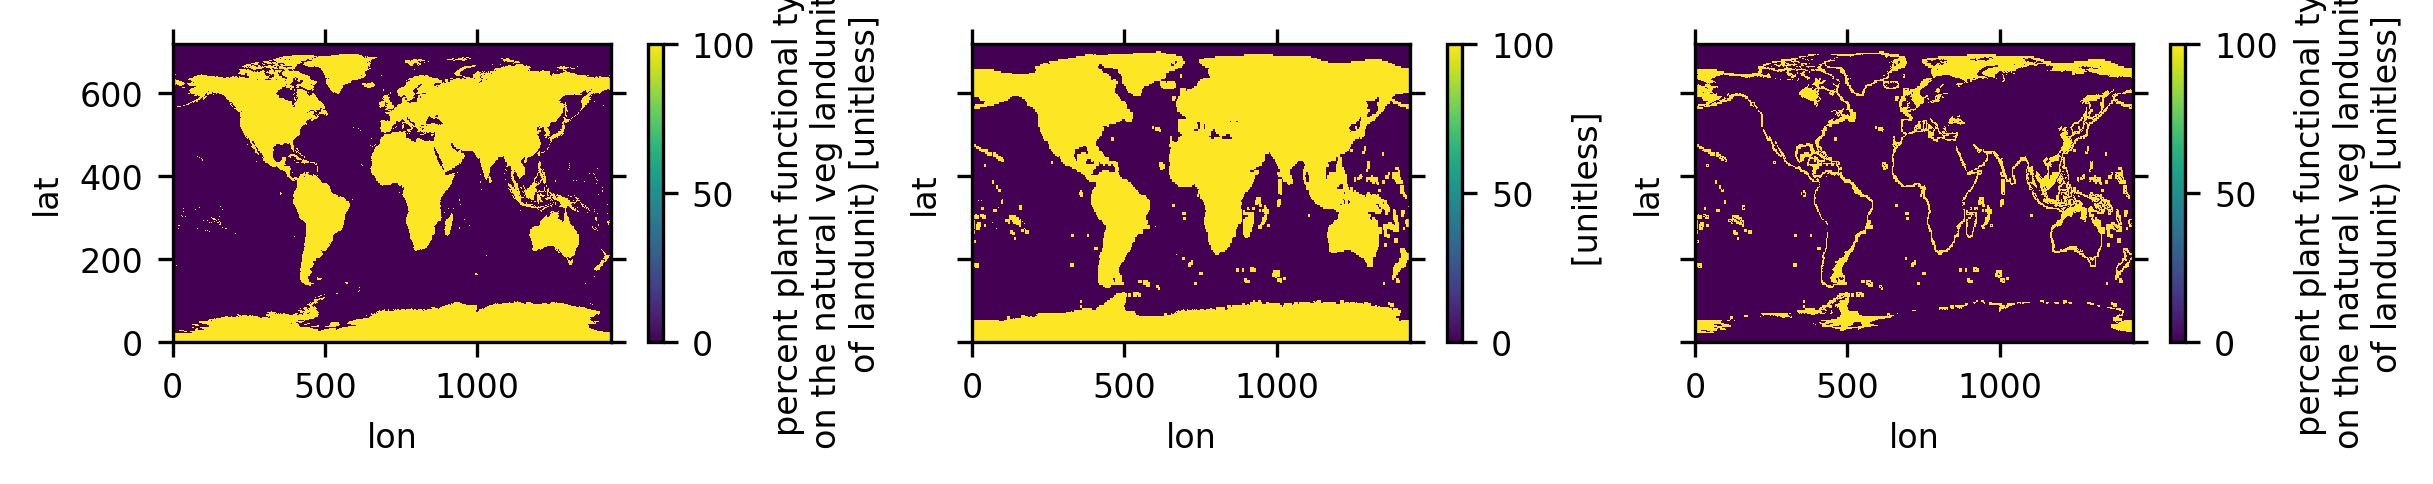

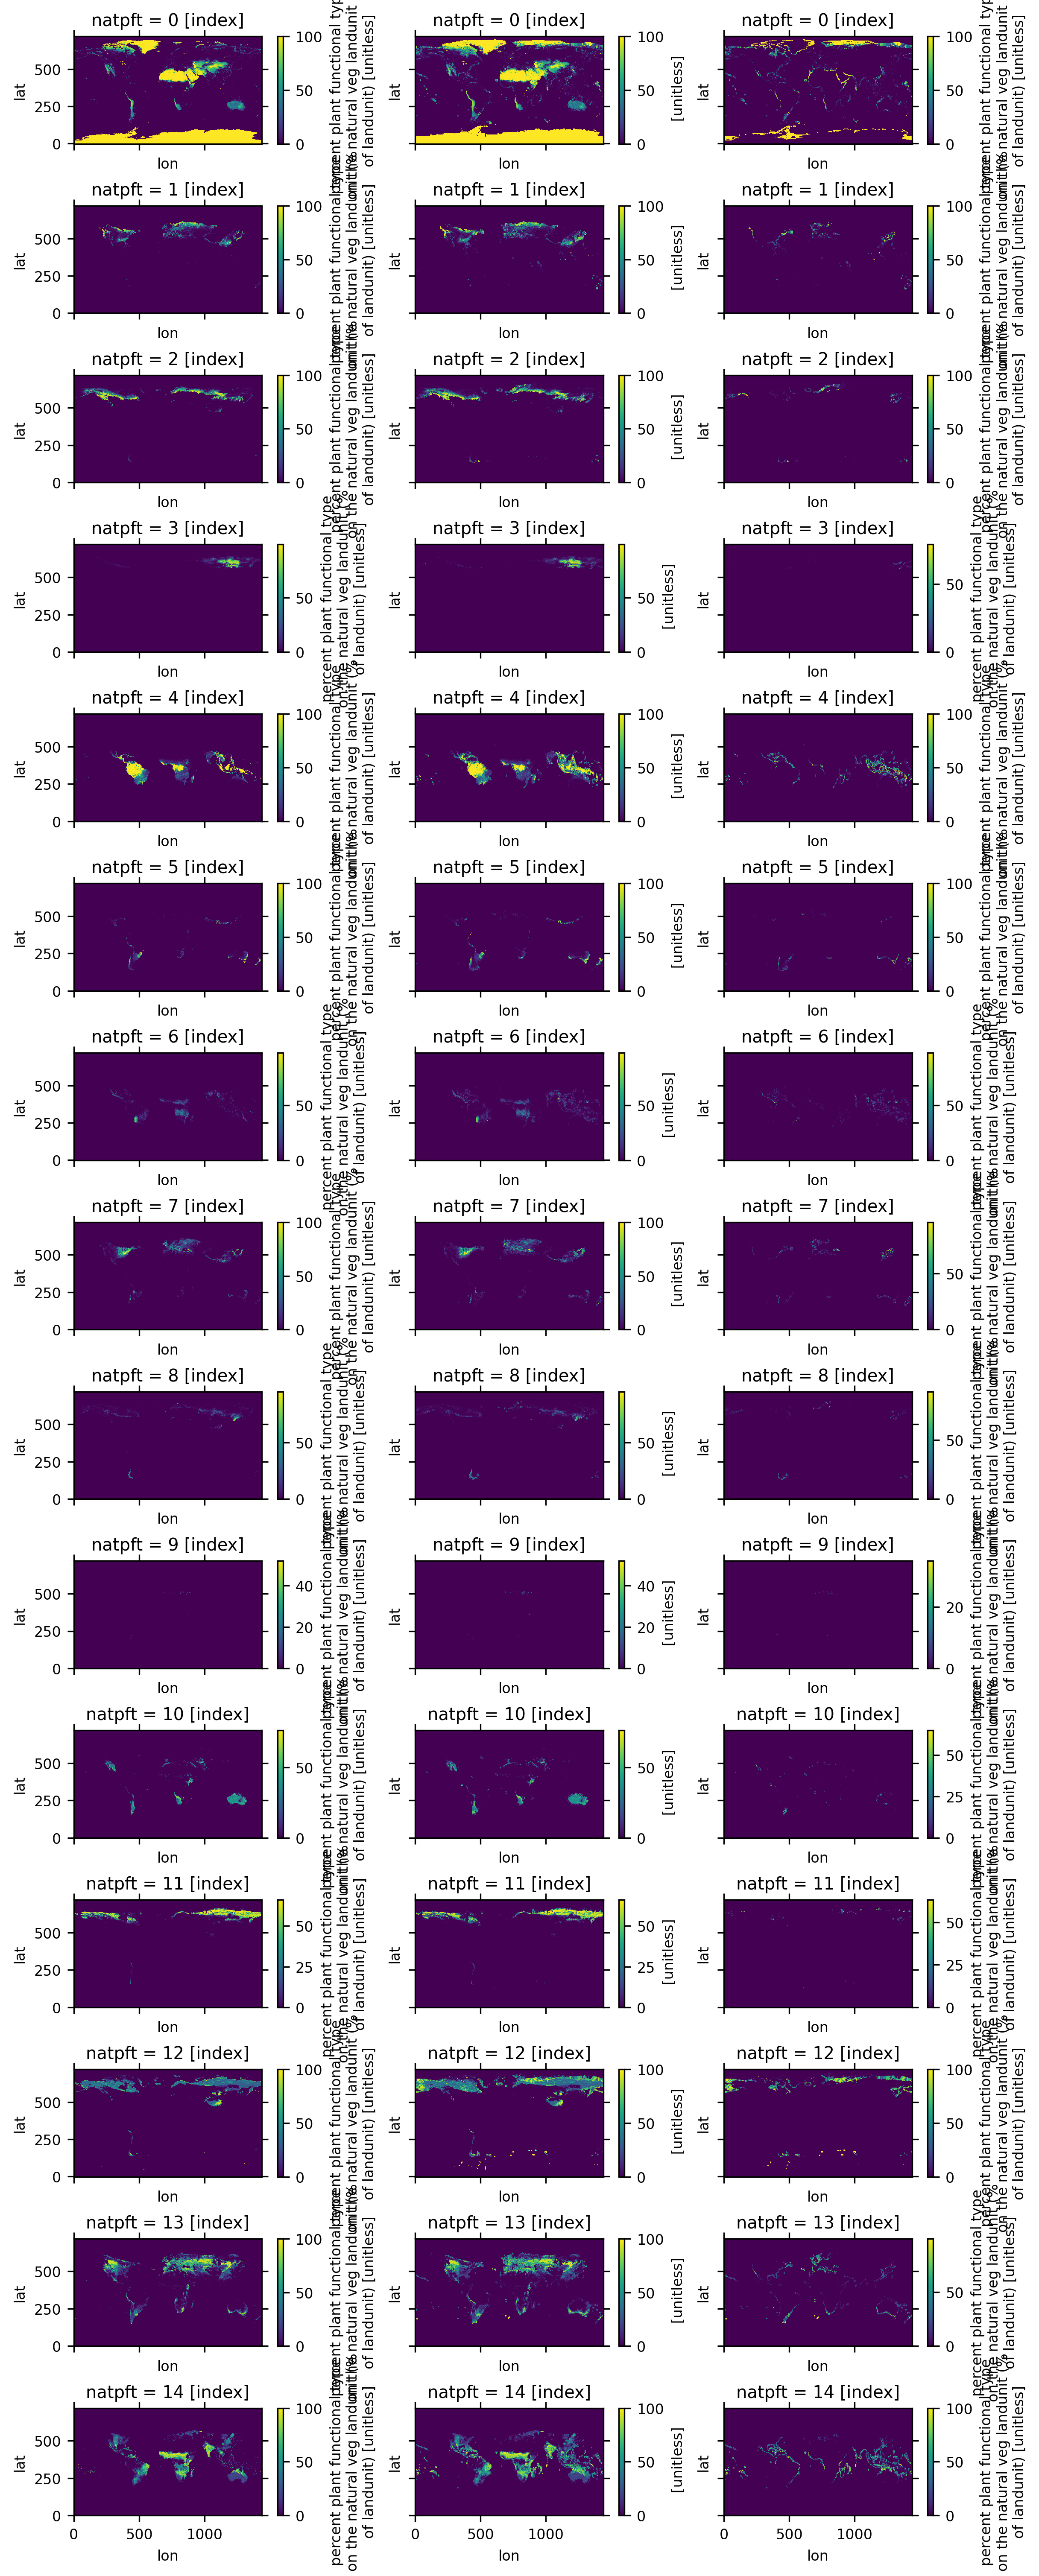

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(8, 1.5),
                         sharex=True, sharey=True,
                         constrained_layout=True)

ds_pft.PCT_NAT_PFT.sum('natpft').plot(ax=axes[0])
(ds_pft_lgm.PCT_NAT_PFT.sum('natpft')*ds_pft_lgm.LANDMASK).plot(ax=axes[1])
(ds_pft_lgm.PCT_NAT_PFT.sum('natpft')*ds_pft_lgm.LANDMASK - \
    ds_pft.PCT_NAT_PFT.sum('natpft')).plot(ax=axes[2])

fig, axes = plt.subplots(15, 3, figsize=(8, 20),
                         sharex=True, sharey=True,
                         constrained_layout=True)

for i_pft in ds_pft_lgm.natpft.values:
    ds_pft.PCT_NAT_PFT.isel(natpft=i_pft).plot(ax=axes[i_pft, 0])
    lgm_var = ds_pft_lgm.PCT_NAT_PFT.isel(natpft=i_pft)*ds_pft_lgm.LANDMASK
    lgm_var.plot(ax=axes[i_pft, 1])
    (lgm_var - ds_pft.PCT_NAT_PFT).isel(natpft=i_pft).plot(ax=axes[i_pft, 2])

In [32]:
# Free up memory
ds_pft.close()
ds_pft_lgm.close()

for var in ['lnd_lgm_i6g_interp', 'lnd_ano_i6g_interp',
            'lnd_lgm_i6g_interp', 'glc_ano_i6g_interp']:
    if var in globals():
        del globals()[var]

---
## Step 4: Create the LGM mksrf_fglacier
- The original raw surface dataset was generated from high-resolution (30-arcsecond) files.
- For simplicity and computational efficiency, we work directly on the existing 3-arcminute resolution raw file.
- In the preindustrial raw dataset, `PCT_GLACIER`, `PCT_GLC_ICESHEET.sum('z')`, and `PCT_GLC_GIC.sum('z')` can slightly exceed 100%. This is most likely an interpolation artifact introduced during remapping. The discrepancy is small and is therefore ignored in the following analysis.

In [33]:
glc_file = nml_dict['mksurfdata_input']['mksrf_fglacier']

fname = Path(Path(glc_file).name)
lgm_glc_file = f"{work_dir}/{fname.stem}_21ka{fname.suffix}"

print(f"Input : {glc_file}")
print(f"Output: {lgm_glc_file}")

ds_glc = xr.open_dataset(glc_file)
ds_glc_lgm = ds_glc.copy(deep=True)

print(f"Lon range: {ds_glc.LONGXY.min():.2f} to {ds_glc.LONGXY.max():.2f}")

ds_glc

Input : /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/mksrf_glacier_3x3min_simyr2000.c20210708.nc
Output: /glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/mksrf_glacier_3x3min_simyr2000.c20210708_21ka.nc
Lon range: -179.98 to 179.98


<xarray.Dataset> Size: 15GB
Dimensions:           (lat: 3600, lon: 7200, z: 71, z_edge: 72)
Dimensions without coordinates: lat, lon, z, z_edge
Data variables:
    PCT_GLACIER       (lat, lon) float32 104MB ...
    LANDMASK          (lat, lon) float32 104MB ...
    TOPO              (lat, lon) float32 104MB ...
    BIN_CENTERS       (z) float32 284B ...
    BIN_EDGES         (z_edge) float32 288B ...
    LAT               (lat) float32 14kB ...
    LON               (lon) float32 29kB ...
    LATIXY            (lat, lon) float32 104MB ...
    LONGXY            (lat, lon) float32 104MB -180.0 -179.9 ... 179.9 180.0
    PCT_GLC_GIC       (z, lat, lon) float32 7GB ...
    PCT_GLC_ICESHEET  (z, lat, lon) float32 7GB ...
Attributes:
    creation_date:  Thu Jul  8 18:53:28 MDT 2021
    title:          CTSM percent glacier dataset and associated topography ve...
    summary:        (See description.)
    creator:        Rene Wijngaard and Adam Herrington
    contact:        CISM Subboard at https://bb.cgd.ucar.edu
    data_script:    https://docs.google.com/document/d/1HZxoyzvcnIpt6q6OuO_L6...
    description:    The updated glacier dataset (version 2) uses glacier outl...

### Make plots of variables

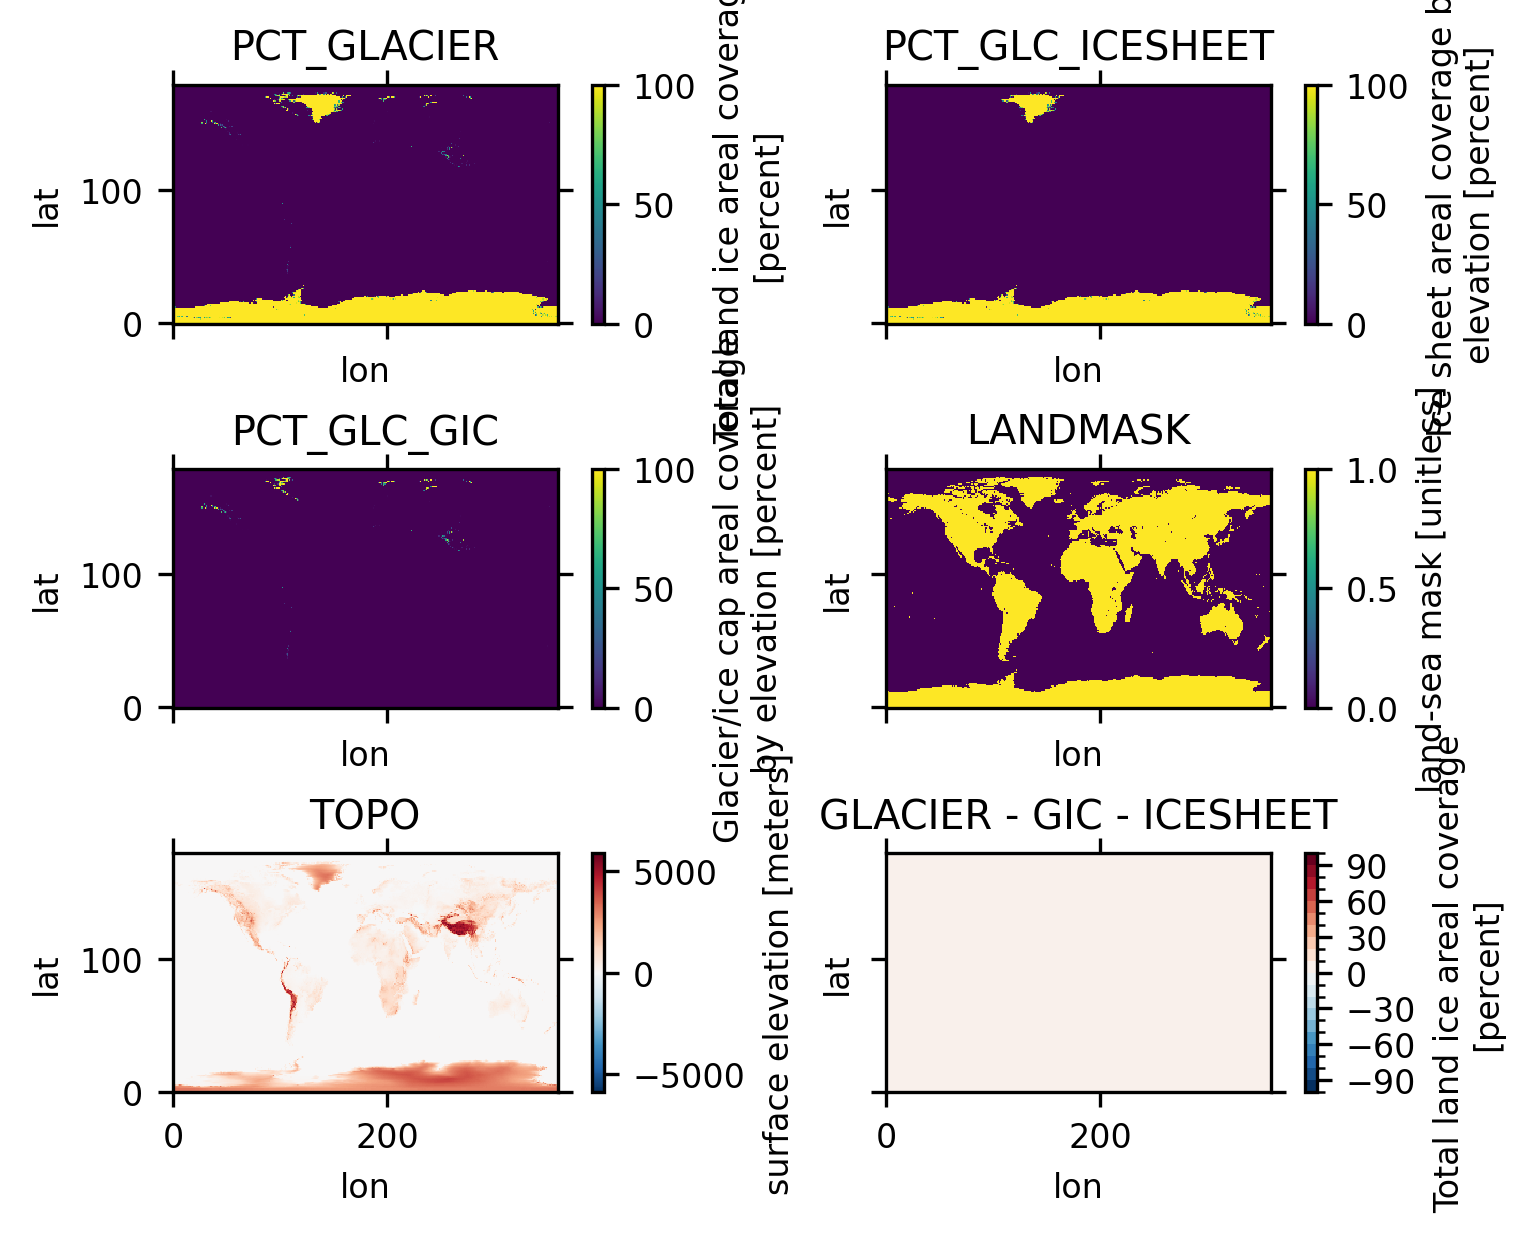

In [34]:
fig, axes = plt.subplots(3, 2, figsize=(5, 4),
                         sharex=True, sharey=True,
                         constrained_layout=True)
axes = axes.ravel()

ds_glc_thin = ds_glc.isel(lat=slice(None, None, 20), lon=slice(None, None, 20))

# Variables to plot in the first five panels
plot_vars = ['PCT_GLACIER', 'PCT_GLC_ICESHEET', 'PCT_GLC_GIC', 'LANDMASK', 'TOPO']

for vname, ax in zip(plot_vars, axes[:5]):
    if vname in ['PCT_GLC_GIC', 'PCT_GLC_ICESHEET']:
        var = ds_glc_thin[vname].sum('z')
    else:
        var = ds_glc_thin[vname]

    # Plot
    var.plot(ax=ax)
    ax.set_title(vname)

# Sixth panel: difference between PCT_GLACIER and the sum of GIC + ICE sheet
var_diff = ds_glc_thin['PCT_GLACIER'] - (ds_glc_thin.PCT_GLC_GIC.sum('z') + ds_glc_thin.PCT_GLC_ICESHEET.sum('z'))
var_diff.plot(ax=axes[5], cmap='RdBu_r', levels=np.linspace(-100, 100, 21))
axes[5].set_title('GLACIER - GIC - ICESHEET')

# Release memory
del var, var_diff

### Take a look at Greenland Summit

In [35]:
idx_lat = 3250
idx_lon = 2800

idx_lat = 3250
idx_lon = 2600

idx_lat = 3250
idx_lon = 2550

ds = ds_glc

bins_e = ds.BIN_EDGES.values
bins_c = ds.BIN_CENTERS.values
print(f"BIN_EDGES: {bins_e}")
print(f"BIN_CENTERS: {bins_c}")
print(f"bin spacing: {np.diff(bins_c)}")
print(f"Examine point: lat = {ds.LAT.isel(lat=idx_lat).values:5.2f}, lon = {ds.LON.isel(lon=idx_lon).values:5.2f}")

for vname in ['PCT_GLACIER', 'LANDMASK', 'TOPO', 'PCT_GLC_GIC', 'PCT_GLC_ICESHEET']:
    print(f"{vname}: {ds[vname].isel(lat=idx_lat, lon=idx_lon).values}")

bin_idx = np.digitize(ds.TOPO.isel(lat=idx_lat, lon=idx_lon), bins_e)
print(bin_idx)
print(bins_c[bin_idx-1])
print(np.nonzero(ds.PCT_GLC_ICESHEET.isel(lat=idx_lat, lon=idx_lon).values)[0])

BIN_EDGES: [    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000. 10000.]
BIN_CENTERS: [  50.  150.  250.  350.  450.  550.  650.  750.  850.  950. 1050. 1150.
 1250. 1350. 1450. 1550. 1650. 1750. 1850. 1950. 2050. 2150. 2250. 2350.
 2450. 2550. 2650. 2750. 2850. 2950. 3050. 3150. 3250. 3350. 3450. 3550.
 3650. 3750. 3850. 3950. 4050. 4150. 4250. 4350. 4450. 4550. 4650. 4750.
 4850. 4950. 5050. 5150. 5250. 5350. 5450. 5550. 5650. 5750. 5850. 5950.
 6050. 6150. 6250. 6350. 6450. 6550. 6650. 6750. 6850. 6950. 7050.]
bin spacing: [100. 100. 100. 1

### Step 4.1 Create the LGM LANDMASK and TOPO

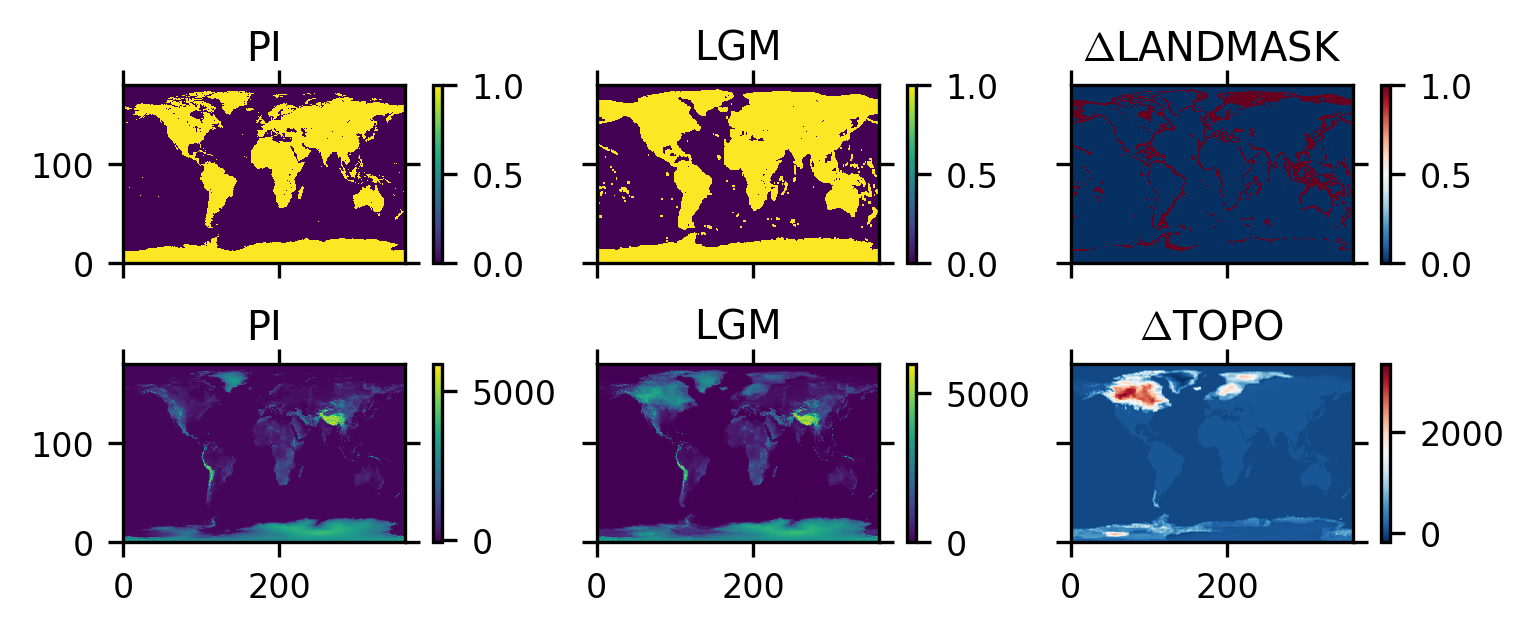

In [36]:

# Interpolate ICE-6G
glc_lgm_i6g_interp = interp_i6g_to(ds_glc, glc_lgm_i6g)
glc_ano_i6g_interp = interp_i6g_to(ds_glc, glc_ano_i6g)
lnd_ano_i6g_interp = interp_i6g_to(ds_glc, lnd_ano_i6g)
oro_ano_i6g_interp = interp_i6g_to(ds_glc, oro_ano_i6g)

has_new_lnd = lnd_ano_i6g_interp > pct_tol
has_new_glc = glc_ano_i6g_interp > pct_tol
is_full_glc = glc_lgm_i6g_interp >= (100.0 - pct_tol)

# Update LANDMASK
# - Force land where new land appears OR where glacier is essentially complete
# - Otherwise keep the original LANDMASK
ds_glc_lgm["LANDMASK"] = ds_glc_lgm["LANDMASK"].where(
    ~(has_new_lnd | is_full_glc),
    1,
).astype(ds_glc["LANDMASK"].dtype)

# Update TOPO
ds_glc_lgm['TOPO'] = ds_glc.TOPO + oro_ano_i6g_interp

# Make plots
fig, axes = plt.subplots(2, 3, figsize=(5, 2),
                         sharex=True, sharey=True,
                         constrained_layout=True)
axes = axes.ravel()

def plot_panel(ax, da, title, cmap=None):
    pcm = ax.pcolormesh(da.thin(20), cmap=cmap)
    ax.set_title(title)
    plt.colorbar(pcm, ax=ax)

plot_panel(axes[0], ds_glc.LANDMASK, 'PI')
plot_panel(axes[1], ds_glc_lgm.LANDMASK, 'LGM')
plot_panel(axes[2], ds_glc_lgm.LANDMASK - ds_glc.LANDMASK, r'$\Delta$LANDMASK', 'RdBu_r')

plot_panel(axes[3], ds_glc.TOPO, 'PI')
plot_panel(axes[4], ds_glc_lgm.TOPO, 'LGM')
plot_panel(axes[5], ds_glc_lgm.TOPO - ds_glc.TOPO, r'$\Delta$TOPO', 'RdBu_r')

### Step 4.2 Create PCT_GLC_ICESHEET, PCT_GLC_GIC and PCT_GLACIER
- For `PCT_GLC_ICESHEET`, use `np.digitize` to compute the new elevation class
- For `PCT_GLC_GIC`, for simplicity, I did not adjust non-LGM-glaciated regions. For example, glaciers over the Himalaya are not changes in coverage and elevation class.
  - It is imperfect to ingore the sea level and GIA effects (i.e. the Himalayan glaciers should have been in higher elevation class) but I don't think it impacts simulation results much.
- Ideally, it should be more accurate if we directly work with the orignal land ice coverage data in 30arcsec.

#### Explor np.digitize

In [37]:
print(bins_e)
print(len(bins_e))
print(f"Digitized idx for -50 m   : {np.digitize(-50, bins_e)}")
print(f"Digitized idx for   0 m   : {np.digitize(0, bins_e)}")
print(f"Digitized idx for  50 m   : {np.digitize(50, bins_e)}")
print(f"Digitized idx for 100050 m: {np.digitize(100050, bins_e)}")

[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000. 10000.]
72
Digitized idx for -50 m   : 0
Digitized idx for   0 m   : 1
Digitized idx for  50 m   : 1
Digitized idx for 100050 m: 72


In [38]:

# Total LGM ice sheet in percentage (0–100)
ttl_lgm_ice_sheet = (
    ds_glc["PCT_GLC_ICESHEET"].sum('z') + glc_ano_i6g_interp
).clip(max=100.0, min=0.0)

# Enforce 100% over ICE-6G full coverage region
ttl_lgm_ice_sheet = ttl_lgm_ice_sheet.where(~is_full_glc, 100.0)

# LGM elevation-class index from local LGM TOPO
nz = ds_glc["PCT_GLC_ICESHEET"].sizes["z"]
lgm_elev_class = xr.apply_ufunc(np.digitize, ds_glc_lgm.TOPO, bins_e) - 1
lgm_elev_class = lgm_elev_class.clip(0, nz - 1).astype(int)

# Assignment LGM elevation class
lgm_pct_icesheet = xr.zeros_like(ds_glc["PCT_GLC_ICESHEET"])

lgm_pct_icesheet.loc[dict(
    z=lgm_elev_class,
    lat=ds_glc_lgm.lat,
    lon=ds_glc_lgm.lon,
)] = ttl_lgm_ice_sheet

# Update elevation class over all ice-sheet regions
ds_glc_lgm["PCT_GLC_ICESHEET"] = lgm_pct_icesheet

# Remove GIC where ICE-6G ice exists
ds_glc_lgm["PCT_GLC_GIC"] = ds_glc_lgm["PCT_GLC_GIC"].where(~has_new_glc, 0.0)

ds_glc_lgm["PCT_GLACIER"] = (ds_glc_lgm["PCT_GLC_GIC"] + ds_glc_lgm["PCT_GLC_ICESHEET"]).sum("z")

#### Make plots to check results

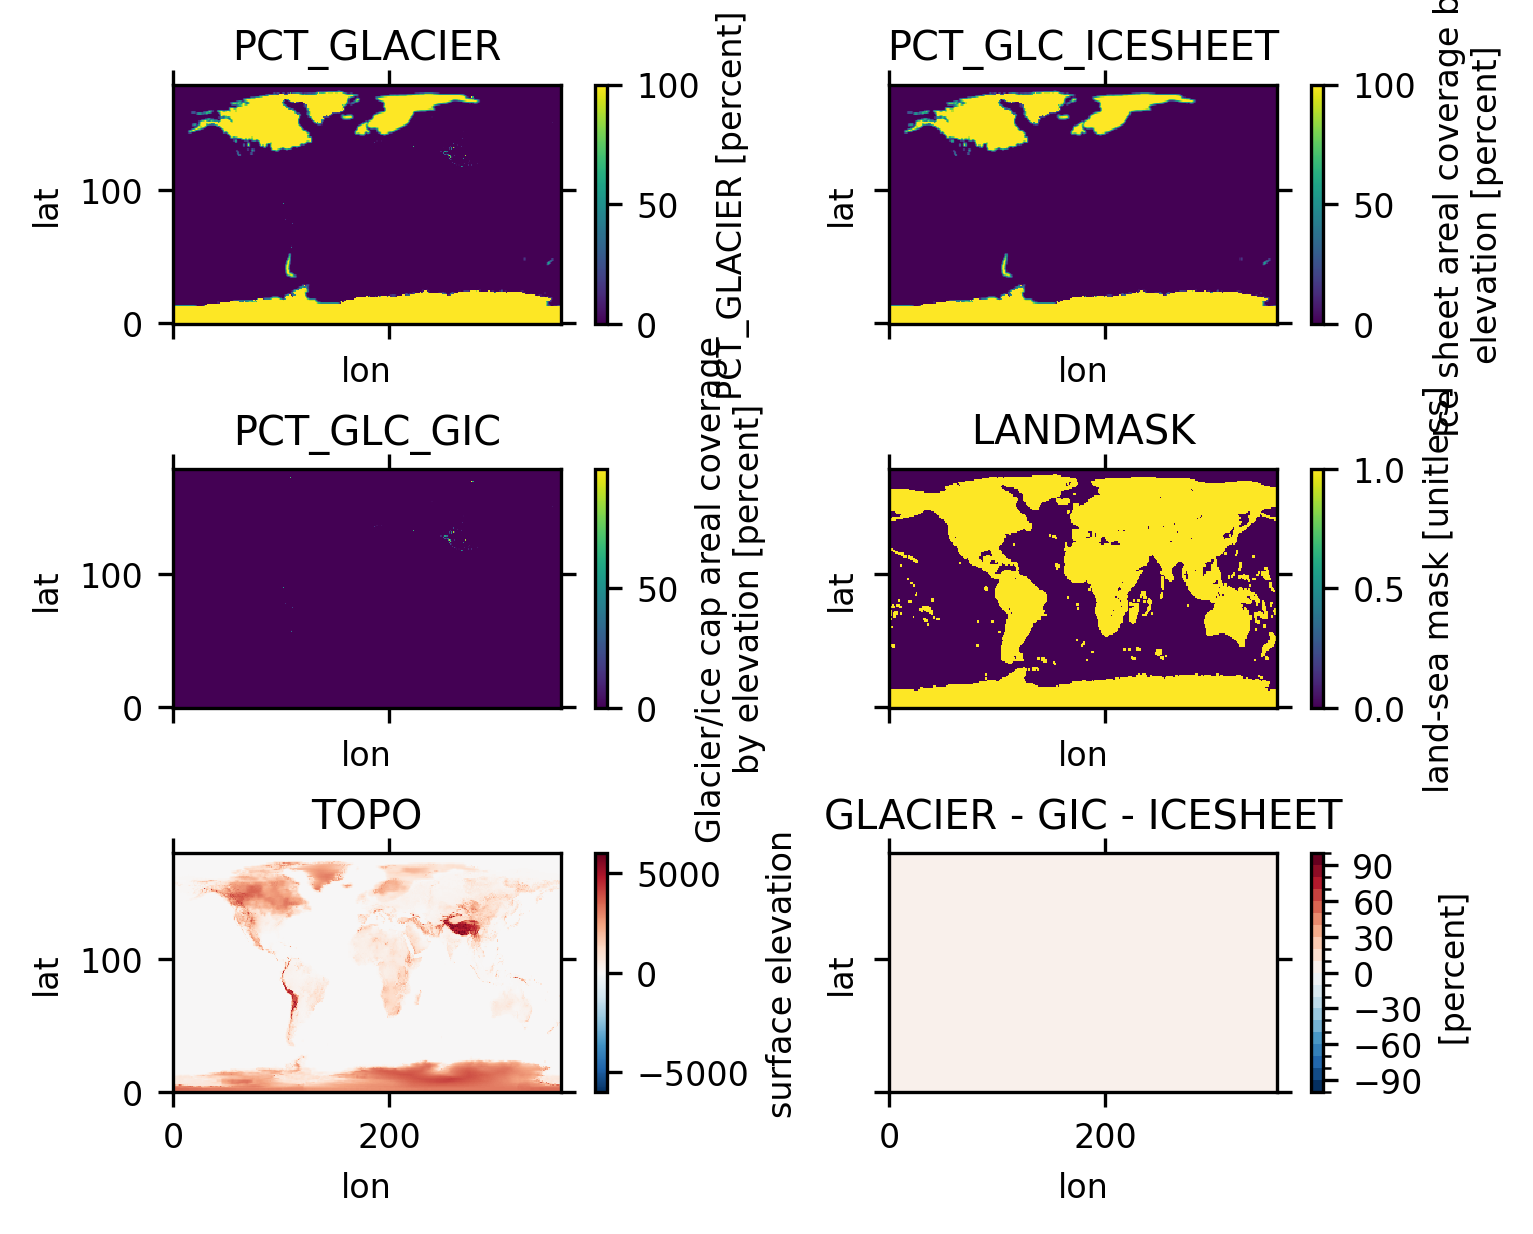

In [39]:
fig, axes = plt.subplots(3, 2, figsize=(5, 4),
                         sharex=True, sharey=True,
                         constrained_layout=True)
axes = axes.ravel()

ds_glc_lgm_thin = ds_glc_lgm.isel(lat=slice(None, None, 20), lon=slice(None, None, 20))

# Variables to plot in the first five panels
plot_vars = ['PCT_GLACIER', 'PCT_GLC_ICESHEET', 'PCT_GLC_GIC', 'LANDMASK', 'TOPO']

for vname, ax in zip(plot_vars, axes[:5]):
    if vname in ['PCT_GLC_GIC', 'PCT_GLC_ICESHEET']:
        var = ds_glc_lgm_thin[vname].sum('z')
    else:
        var = ds_glc_lgm_thin[vname]

    # Plot
    var.plot(ax=ax)
    ax.set_title(vname)

# Sixth panel: difference between PCT_GLACIER and the sum of GIC + ICE sheet
var_diff = ds_glc_lgm_thin['PCT_GLACIER'] - (ds_glc_lgm_thin.PCT_GLC_GIC.sum('z') + ds_glc_lgm_thin.PCT_GLC_ICESHEET.sum('z'))
var_diff.plot(ax=axes[5], cmap='RdBu_r', 
              levels=np.linspace(-100, 100, 21))
axes[5].set_title('GLACIER - GIC - ICESHEET')

# Release memory
del var, var_diff

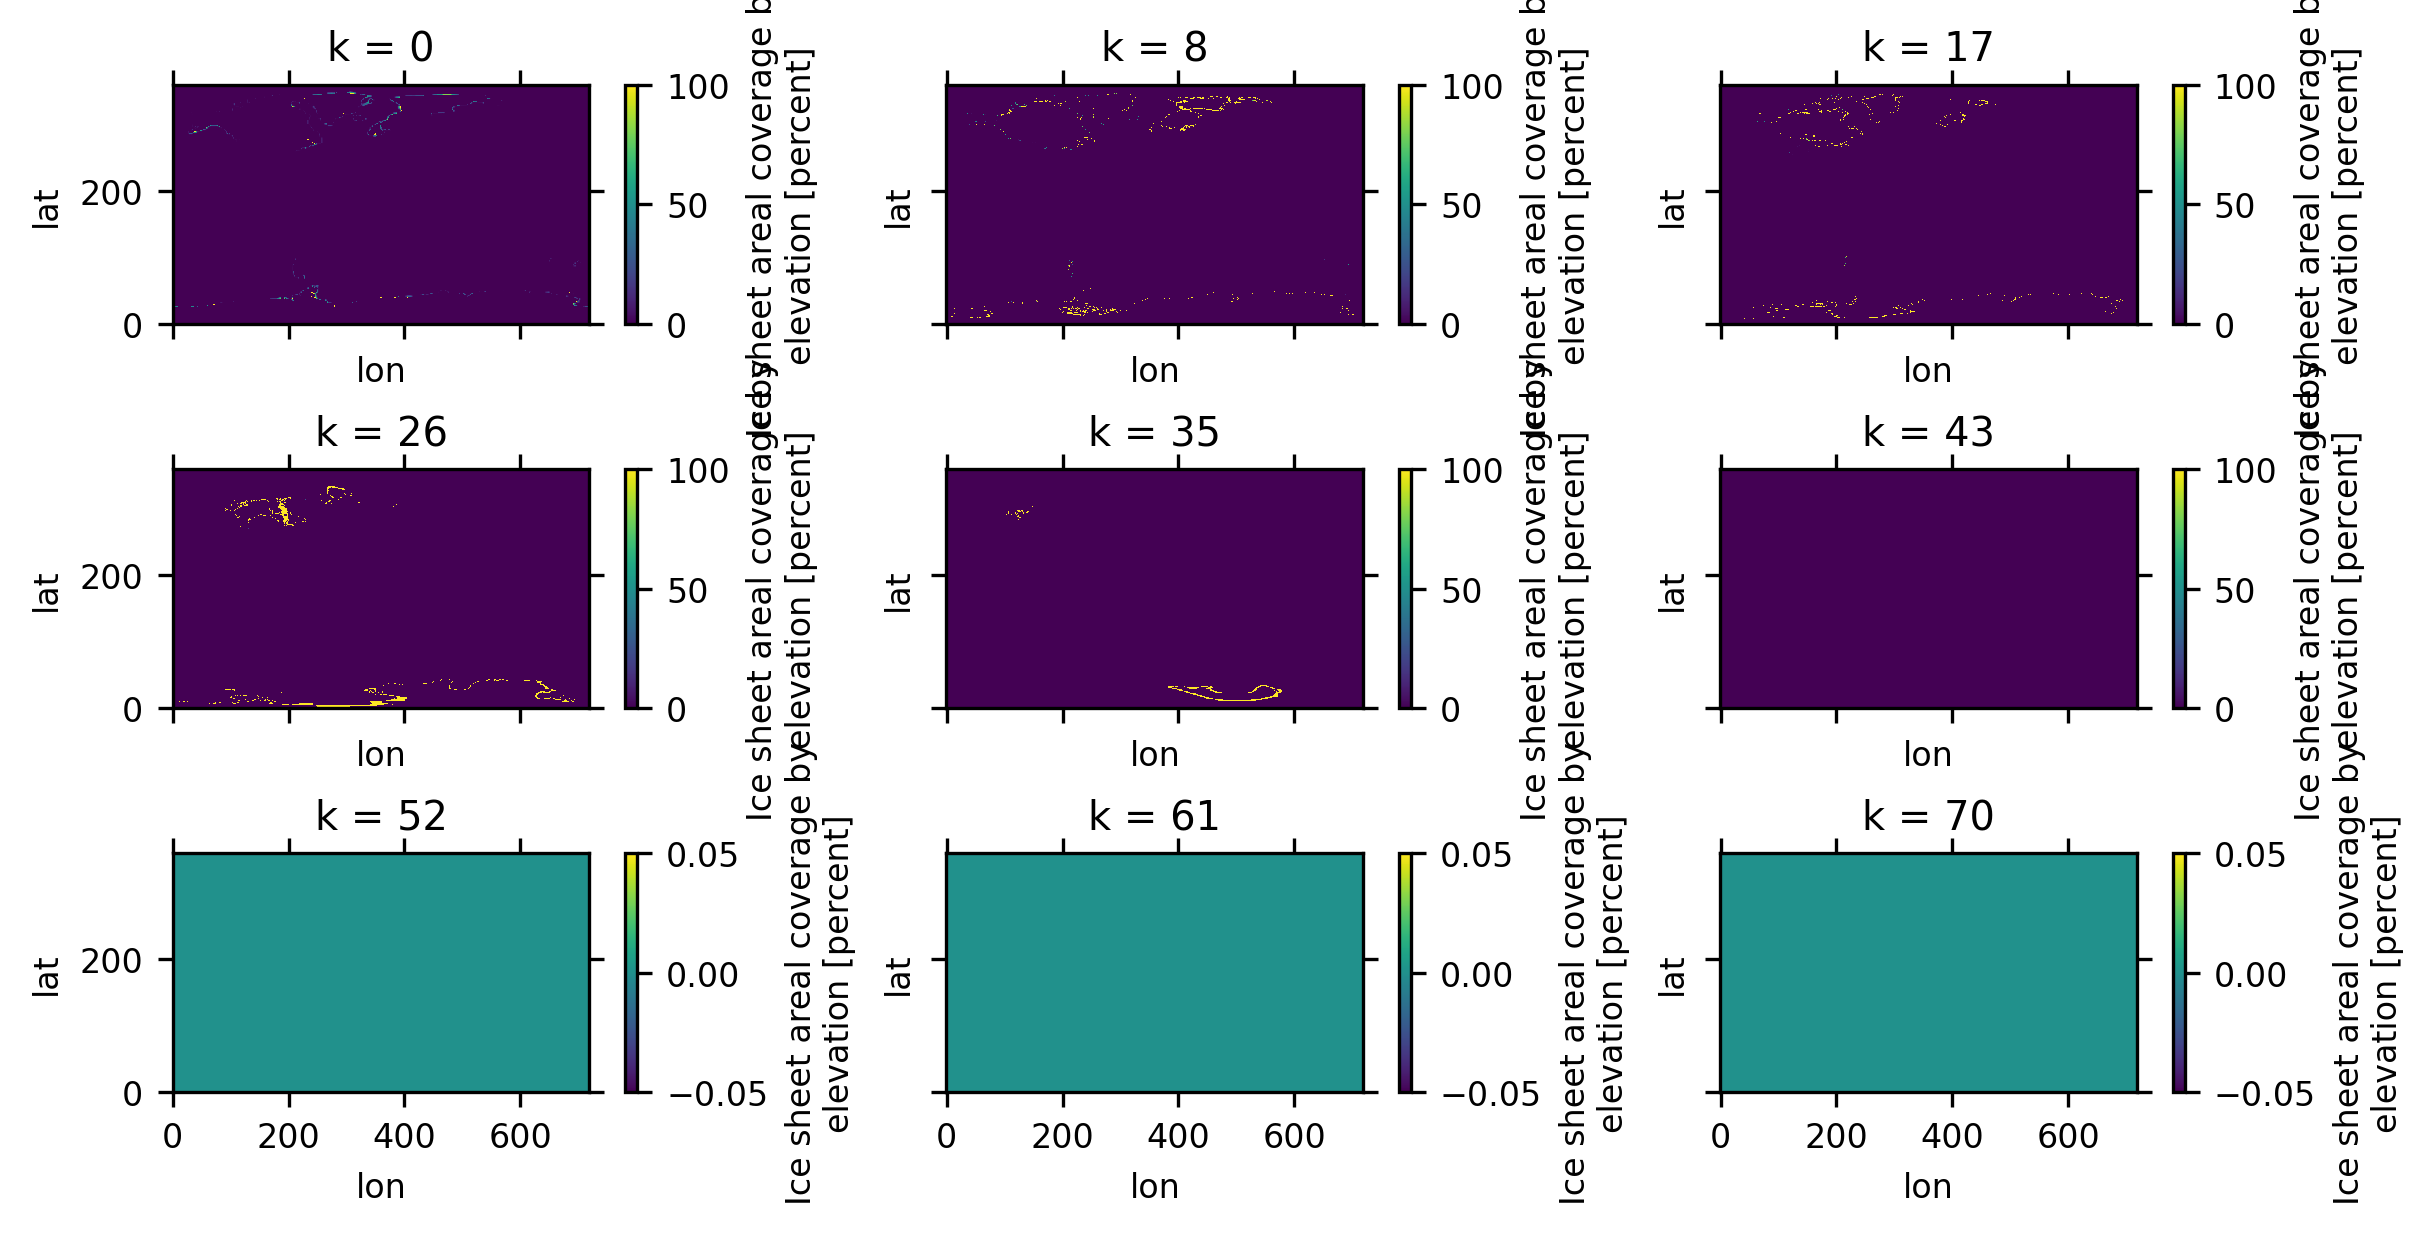

In [40]:
fig, axes = plt.subplots(3, 3, figsize=(8, 4),
                         sharex=True, sharey=True,
                         constrained_layout=True)
axes = axes.ravel()

for i_elev, ax in zip(np.linspace(0, 70, 9).astype(int), axes):
    ds_glc_lgm.PCT_GLC_ICESHEET.isel(z=i_elev).thin(10).plot(ax=ax)
    ax.set_title(f"k = {i_elev}")

### Take a look at a grid point over the Laurentide Ice Sheet

In [41]:
idx_lat = 3000
idx_lon = 1500

ds = ds_glc_lgm

print(f"Examine point: lat = {ds.LAT.isel(lat=idx_lat).values:5.2f}, lon = {ds.LON.isel(lon=idx_lon).values:5.2f}")

for vname in ['PCT_GLACIER', 'LANDMASK', 'TOPO', 'PCT_GLC_GIC', 'PCT_GLC_ICESHEET']:
    print(f"{vname}: {ds[vname].isel(lat=idx_lat, lon=idx_lon).values}")

bins_e = ds.BIN_EDGES.values
bins_c = ds.BIN_CENTERS.values
print(f"BIN_EDGES: {bins_e}")
print(f"BIN_CENTERS: {bins_c}")
print(f"bin spacing: {np.diff(bins_c)}")
bin_idx = np.digitize(ds.TOPO.isel(lat=idx_lat, lon=idx_lon), bins_e)
print(bin_idx)

print(bins_c[bin_idx-1])

print(np.nonzero(ds.PCT_GLC_ICESHEET.isel(lat=idx_lat, lon=idx_lon).values)[0])

Examine point: lat = 60.03, lon = -104.97
PCT_GLACIER: 100.0
LANDMASK: 1.0
TOPO: 3498.044942346313
PCT_GLC_GIC: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PCT_GLC_ICESHEET: [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]
BIN_EDGES: [    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  39

### Save the LGM glacier file and update the namelist

In [42]:
%%time

ds_glc_lgm.to_netcdf(lgm_glc_file)
subprocess.run(['ncks', "-hO5", lgm_glc_file, lgm_glc_file])

for grid, cfg in grid_configs.items():
    cfg['lgm_nml_dict']['mksurfdata_input']['mksrf_fglacier'] = lgm_glc_file

CPU times: user 1.64 s, sys: 13.8 s, total: 15.4 s
Wall time: 1min 10s


In [43]:
# Free up memory
ds_glc.close()
ds_glc_lgm.close()

del lgm_pct_icesheet

for var in ['lnd_lgm_i6g_interp', 'lnd_ano_i6g_interp',
            'lnd_lgm_i6g_interp', 'glc_ano_i6g_interp']:
    if var in globals():
        del globals()[var]

### Update the LGM glacier region file

In [44]:
for grid, cfg in grid_configs.items():
    cfg['lgm_nml_dict']['mksurfdata_input']['mksrf_fglacierregion'] = '/glade/campaign/cesm/development/palwg/raw_boundary_data/GLACIER_REGION.nc'
    cfg['lgm_nml_dict']['mksurfdata_input']['mksrf_fglacierregion_mesh'] = '/glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/mappingdata/grids/UNSTRUCTgrid_0.9x1.25_nomask_cdf5_c200129.nc'

---
## Step 5: Write the final namelist file and run mksurfdata
⚠️**CHECK THE NAMELIST FILE CAREFULLY BEFORE RUNNING.**
- You need to submit jobs to run on Derecho

### Write namelist files

In [45]:
for grid, cfg in grid_configs.items():
    print(f"\n{grid}: {cfg['lgm_nml']}\n")

    lgm_nml_dict = cfg['lgm_nml_dict']
    f90nml.write(lgm_nml_dict, cfg['lgm_nml'], force=True)

    for key in lgm_nml_dict['mksurfdata_input'].keys():
        print(f"{key}: {lgm_nml_dict['mksurfdata_input'][key]}")


ne30np4.pg3: /glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/surfdata_ne30np4.pg3_PtVeg_nourb_1850_16pfts_21ka_c260118.namelist

mksrf_fgrid_mesh: /glade/campaign/cesm/cesmdata/inputdata/share/meshes/ne30pg3_ESMFmesh_cdf5_c20211018.nc
mksrf_fgrid_mesh_nx: 48600
mksrf_fgrid_mesh_ny: 1
mksrf_flai: /glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/mksrf_pftlai_clm6_histLUH3_2005_c251012_21ka_nnfilled.nc
mksrf_flai_mesh: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/mappingdata/grids/UNSTRUCTgrid_0.25x0.25_nomask_cdf5_c200129.nc
mksrf_fsoicol: /glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/mksrf_soilcolor_clm6_histLUH3_2005_c251012_21ka_nnfilled.nc
mksrf_fsoicol_mesh: /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/mappingdata/grids/UNSTRUCTgrid_0.25x0.25_nomask_cdf5_c200129.nc
mksrf_fsoitex: /glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/mksrf_soil_mapunits_5x5min_w_latlon_WISE.c220330_21ka_nnfilled.nc
mksrf_fsoitex_lookup: /glade/campaign/

### Write job script and submit to Derecho
- Note the line `#PBS -q main@desched1`, which is used to submit job to Derecho from Casper
- Change it to `#PBS -q main`, if you are submitting job to Derecho from Derecho
- It may take ~15 minutes to finish file for one grid on one Derecho node.
- Carefully compare the result with `/glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/surfdata_esmf/ctsm5.4.0/surfdata_ne30np4.pg3_PtVeg_nourb_1850_16pfts_c251022.nc`

In [46]:
script_path = f"{work_dir}/mksurfdata_jobscript.sh"

pbs_script = f"""#!/bin/bash
#PBS -N mksurfdata
#PBS -A P93300324
#PBS -q main@desched1
#PBS -l select=1:ncpus=128:mpiprocs=128
#PBS -l walltime=2:00:00
#PBS -l JOB_PRIORITY=premium
#PBS -j oe

cd {mksurfdata_dir}

. {mksurfdata_dir}/tool_bld/.env_mach_specific.sh

"""

# Loop over grids
for grid, cfg in grid_configs.items():
    namelist = cfg["lgm_nml"]
    pbs_script += f'mpibind {mksurfdata_exe} < {namelist} \n\n'

# Write the script and make it executable
with open(script_path, "w") as f:
    f.write(pbs_script)

os.chmod(script_path, 0o755)

print(f"PBS script created at {script_path}")

PBS script created at /glade/derecho/scratch/jiangzhu/setup_data/mksurfdata_esmf/mksurfdata_jobscript.sh


In [47]:
! qsub $script_path

4673667.desched1
